In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from typing import Iterable

In [3]:
import rich
import rich.table

import dataclasses

# HookedTransformer

* [TransformerLens - Tutorial - Trains HookedTransformer from Scratch](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/No_Position_Experiment.ipynb)

```python
import transformers

# note: it's probably easier to just operate on tokens outside of the model,
#       that'll also make it clearer where tokenizer is used
#
# okay wrapping a pretrained tokenizer *can* be done:
# - https://huggingface.co/learn/nlp-course/chapter6/8#building-a-bpe-tokenizer-from-scratch
# - but none of the models support just naive encoding
#   - https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE
class HookedTransformer:
    cfg: HookedTransformerConfig

    # note: actually does an `isinstance` check in the constructor
    tokenizer: transformers.PreTrainedTokenizerBase | None
```

In [4]:
import transformer_lens

from jaxtyping import Int64, Float32

import numpy as np
import plotly.express as px
import plotly.io as pio

import torch
import torch.utils.data

In [5]:
# plotting code copied over from transformer_lens tutorial notebook


def line(tensor: torch.Tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor: torch.Tensor, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

In [6]:
device = transformer_lens.utils.get_device()

print(f"Using device: {device}")

Using device: mps


### Setup Sample Generator

In [25]:
import string
import itertools
import more_itertools


class SpecialToken:
    # note: as assume a BOS token because transformerlens expects it
    BOS = "<"
    # we use a EOS token for convenience
    EOS = ">"


# note: without length, the model doesn't need to learn induction heads, just directly copies


# TODO(bschoen): Allow this to generalize in the future
#
# Good for purely attention, since seeing patterns
def generate_sample_palindrome_then_repeated() -> Iterable[str]:
    """Generate palindrom samples like `<abc|cba|abc>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    lengths = [2, 3, 4, 5, 6, 7]

    # pad to max length
    max_length = (
        1 + max(lengths) + 1 + max(lengths) + 1 + max(lengths) + 1 + max(lengths) + 1
    )

    # set max number to take of each length
    max_combinations_per_length = 10000

    for length in lengths:

        for combination_index, combination in enumerate(
            itertools.product(characters, repeat=length)
        ):

            if combination_index > max_combinations_per_length:
                break

            combination_str = "".join(combination)
            reversed_str = "".join(reversed(combination_str))

            sample = (
                SpecialToken.BOS
                + combination_str
                + "|"
                + reversed_str
                + "|"
                + combination_str
                + SpecialToken.EOS
            )

            # Pad the sample to max_length with EOS tokens
            padded_sample = sample.ljust(max_length, SpecialToken.EOS)

            yield padded_sample  # Return the padded sample


# TODO(bschoen): For this do we get like a "next biggest" head?
# TODO(bschoen): Can we do circuit analysis on this?
def generate_sample_sorted() -> Iterable[str]:
    """Generate sequence sorted `<cab|abc>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    # lengths = [3, 4, 5, 6, 7]
    # lengths = [2, 3, 4, 5]  # , 6, 7]
    lengths = [4]

    # pad to max length
    max_length = 1 + max(lengths) + 1 + max(lengths) + 1

    # set max number to take of each length
    # max_combinations_per_length = 10000

    for length in lengths:

        for combination_index, combination in enumerate(
            itertools.product(characters, repeat=length)
        ):

            # if combination_index > max_combinations_per_length:
            #    break

            combination_str = "".join(combination)
            sorted_str = "".join(sorted(combination_str))

            sample = (
                SpecialToken.BOS + combination_str + "|" + sorted_str + SpecialToken.EOS
            )

            # Pad the sample to max_length with EOS tokens
            padded_sample = sample.ljust(max_length, SpecialToken.EOS)

            yield padded_sample  # Return the padded sample


generate_sample = generate_sample_sorted

# show a few examples
[x for x in more_itertools.take(10, generate_sample())]

['<aaaa|aaaa>',
 '<aaab|aaab>',
 '<aaac|aaac>',
 '<aaad|aaad>',
 '<aaae|aaae>',
 '<aaaf|aaaf>',
 '<aaag|aaag>',
 '<aaah|aaah>',
 '<aaai|aaai>',
 '<aaaj|aaaj>']

### Setup Tokenizer

In [26]:
from gpt_from_scratch.naive_tokenizer import NaiveTokenizer

vocab = string.ascii_lowercase + "|" + SpecialToken.BOS + SpecialToken.EOS

tokenizer = NaiveTokenizer.from_text(vocab)

In [27]:
from gpt_from_scratch import tokenizer_utils

# test tokenizer
input_text = "<abc|cba|abc><bd|db|bd>>>>"
tokenizer_utils.show_token_mapping(tokenizer, input_text)

Input:		<abc|cba|abc><bd|db|bd>>>>
Tokenized:	<abc|cba|abc><bd|db|bd>>>>
Token ID | Token Bytes | Token String
---------+-------------+--------------
       0 | 3C | '<'
          <abc|cba|abc><bd|db|bd>>>>
          U+003C LESS-THAN SIGN (1 bytes: 3C)
       2 | 61 | 'a'
          <abc|cba|abc><bd|db|bd>>>>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       3 | 62 | 'b'
          <abc|cba|abc><bd|db|bd>>>>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       4 | 63 | 'c'
          <abc|cba|abc><bd|db|bd>>>>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
      28 | 7C | '|'
          <abc|cba|abc><bd|db|bd>>>>
          U+007C VERTICAL LINE (1 bytes: 7C)
       4 | 63 | 'c'
          <abc|cba|abc><bd|db|bd>>>>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
       3 | 62 | 'b'
          <abc|cba|abc><bd|db|bd>>>>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       2 | 61 | 'a'
          <abc|cba|abc><bd|db|bd>>>>
          U+0061 LATIN SMALL LETTER A (1 by

### Setup Loss Function

In [28]:
def loss_fn(logits, target):
    # standard cross entropy loss
    return torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target.view(-1),
    )

### Evaluate On Test

In [29]:
def evaluate_loss_on_test_batches(
    model: transformer_lens.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
    max_batches: int,
) -> float:

    # Set the model to evaluation mode
    model.eval()

    losses = []

    with torch.no_grad():  # Disable gradient computation

        for batch_index, batch in enumerate(data_loader):

            if batch_index > max_batches:
                break

            x, y = batch

            x, y = x.to(device), y.to(device)

            logits = model(x)

            loss = loss_fn(logits, y)

            losses.append(loss.item())

    # Set the model back to training mode
    model.train()

    return sum(losses) / len(losses)

### Setup Data Loaders

In [12]:
class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, samples: list[str], tokenizer: NaiveTokenizer) -> None:
        self.samples = samples
        self.tokenizer = tokenizer  # Assuming tokenizer is defined in the global scope

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        tokens = self.tokenizer.encode(sample)

        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)

        return x, y


def make_batch_dataloader(
    samples: list[str],
    tokenizer: NaiveTokenizer,
    batch_size: int,
) -> tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:

    dataset = AutoregressiveDataset(samples=samples, tokenizer=tokenizer)

    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        # drop the last batch if it's incomplete
        drop_last=True,
    )

    return dataset, dataloader


# Example usage:
# batch_generator = make_batch_generator(tokenizer, batch_size=4)
# for x, y in batch_generator:
#     # x is input, y is target (x shifted by 1)
#     pass

In [31]:
import random

# split into test and train
all_samples = list(generate_sample())

# note: 4394 batches = (26 * 26 * 26) / 4
print(f"{len(all_samples)} samples")

# Randomly shuffle all_samples
random.shuffle(all_samples)  # In-place shuffling of the list

# Inline comment explaining the motivation
# We shuffle the samples to ensure a random distribution of data points
# between the training and test sets, reducing potential bias


# max_samples = 10
# print(f'Capping at {max_samples} batches first to make sure we can overfit')
# all_samples = all_samples[:max_samples]

test_train_ratio = 0.2

test_size = int(test_train_ratio * len(all_samples))

# put remaining ones into train
train_size = len(all_samples) - test_size

train_samples = all_samples[:train_size]
test_samples = all_samples[train_size:]

print(f"{len(train_samples)=}")
print(f"{len(test_samples)=}")

# now we can finally construct dataloaders
# batch_size = 128
batch_size = 512

train_dataset, train_loader = make_batch_dataloader(
    samples=train_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)
# Split test_samples based on the number of '>' characters
test_samples_by_difficulty = {}
for sample in test_samples:
    difficulty = len(sample) - sample.count(">")
    if difficulty not in test_samples_by_difficulty:
        test_samples_by_difficulty[difficulty] = []
    test_samples_by_difficulty[difficulty].append(sample)

# Sort the dictionary by difficulty (number of '>' characters)
test_samples_by_difficulty = dict(
    sorted(test_samples_by_difficulty.items(), reverse=True)
)

# Inline comment explaining the motivation
# We sort the dictionary by difficulty to ensure a consistent order
# when iterating through the difficulty levels, making it easier to
# analyze and compare model performance across increasing complexities

for difficulty, samples in test_samples_by_difficulty.items():
    print(f"{difficulty}: {len(samples)}")

# Create dataloaders for each difficulty level
test_datasets = {}
test_loaders = {}
for difficulty, samples in test_samples_by_difficulty.items():
    test_datasets[difficulty], test_loaders[difficulty] = make_batch_dataloader(
        samples=samples,
        tokenizer=tokenizer,
        batch_size=batch_size,
    )

# Inline comment explaining the motivation
# We split the test samples based on the number of '>' characters to create
# separate datasets for different difficulty levels. This allows us to evaluate
# the model's performance across varying complexities of input sequences.

456976 samples
len(train_samples)=365581
len(test_samples)=91395
10: 91395


### Setup Model

In [32]:
# now we know our vocab size from our sample generation
def make_hooked_transformer_config(
    n_layers: int,
    d_model: int,
    n_heads: int,
) -> transformer_lens.HookedTransformerConfig:

    for sample in generate_sample():
        n_ctx = len(sample)
        break

    cfg = transformer_lens.HookedTransformerConfig(
        n_layers=n_layers,
        d_model=d_model,
        d_head=d_model // n_heads,
        # The number of attention heads.
        # If not specified, will be set to d_in // d_head.
        # (This is represented by a default value of -1)
        n_heads=n_heads,
        # The dimensionality of the feedforward mlp network.
        # Defaults to 4 * d_in, and in an attn-only model is None.
        # TODO(bschoen): Need to try out also setting `attn_only`
        # d_mlp=None,
        # note: transformerlens does the same thing if this is not set
        d_vocab=len(tokenizer.byte_to_token_dict),
        # length of the longest sample is our context length
        n_ctx=n_ctx,
        act_fn="relu",
        # normalization_type="LN",
        normalization_type=None,
        # note: must be set, otherwise tries to default to cuda / cpu (not mps)
        device=device.type,
    )

    print(f"Num params: {cfg.n_params}")

    return cfg

## Setup Image Logging

In [15]:
# Convert matplotlib figure to PNG for wandb upload
import io
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any
from jaxtyping import Float


def fig_to_wandb_image(fig) -> Image:
    """
    Convert a matplotlib figure to a PNG image that can be uploaded to wandb.

    Args:
        fig (matplotlib.figure.Figure): The matplotlib figure to convert

    Returns:
        PIL.Image: The figure as a PIL Image object
    """
    # Save the figure to a byte buffer
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches="tight")
    buf.seek(0)

    # Convert the buffer to a PIL Image
    image = Image.open(buf)
    return image


# note: `title` is passed in for telling them apart in gifs etc
def generate_image_for_attention_patterns(
    input_token_str_to_cache_dict: dict[str, transformer_lens.ActivationCache],
    title: str,
) -> Image:
    """
    Visualize attention patterns for all layers and heads in the model for multiple caches.

    Args:
        caches (List[Dict[str, Any]]): List of caches containing attention patterns from model forward passes.

    Returns:
        plt.Figure: A matplotlib figure containing the visualized attention patterns.
    """
    input_token_strings = list(input_token_str_to_cache_dict.keys())
    caches = list(input_token_str_to_cache_dict.values())

    # Find all attention pattern tensors in the first cache (assuming all caches have the same structure)
    pattern_keys = [
        key for key in caches[0].keys() if key.endswith(".attn.hook_pattern")
    ]

    n_layers = len(pattern_keys)
    n_heads = caches[0][pattern_keys[0]].shape[1]
    n_caches = len(caches)

    # Calculate total number of subplots
    total_subplots = n_layers * n_heads

    # Create a figure with subplots stacked vertically for each cache
    fig, axes = plt.subplots(
        n_caches, total_subplots, figsize=(4 * total_subplots, 4 * n_caches)
    )

    # Set overall figure title
    fig.suptitle(title, fontsize=16)

    # Color maps for alternating heads
    cmaps = ["Blues", "Reds"]

    for cache_idx, cache in enumerate(caches):
        input_token_string = input_token_strings[cache_idx]
        for layer, key in enumerate(pattern_keys):
            attention_pattern = cache[key]

            # Remove batch dimension and move to CPU
            reshaped_pattern = attention_pattern.squeeze(0).detach().cpu().numpy()

            for head in range(n_heads):
                subplot_index = layer * n_heads + head
                ax = (
                    axes[cache_idx, subplot_index]
                    if n_caches > 1
                    else axes[subplot_index]
                )

                # Plot the attention pattern
                im = ax.imshow(reshaped_pattern[head], cmap=cmaps[head % len(cmaps)])

                # Set title for each subplot
                ax.set_title(f"L{layer}-H{head}", fontsize=8)

                # Set column labels as individual characters from input_token_string at the top
                ax.xaxis.tick_top()
                ax.set_xticks(range(len(input_token_string)))
                ax.set_xticklabels(list(input_token_string), fontsize=6, ha="right")

                ax.set_yticks([])  # Remove y-axis ticks

    plt.tight_layout()

    image = fig_to_wandb_image(fig)

    # close figure so doesn't keep taking up memory
    plt.close(fig)

    return image

In [16]:
import glob
from PIL import Image
import os
import pathlib


def convert_pngs_in_directory_to_gif(output_dir: pathlib.Path) -> pathlib.Path:

    # Get a list of all PNG files in the output directory
    # Use rglob for recursive search of PNG files
    png_files = list(output_dir.rglob("*.png"))

    # sort by step
    #
    # files have format
    #
    # - `.../<key>_<step>_<hash-identifier-thing>.png`
    # - ex: `.../attention_100_d8bda3455ffb06855d88.png`
    #
    png_files = sorted(png_files, key=lambda x: int(x.name.split("_")[1]))

    # Create a list to store the image frames
    frames = []

    # Load each PNG file and append it to the frames list
    print(f"Generating gif from {len(png_files)} images...")
    for png_file in png_files:
        # Open the image and convert it to RGB mode (required for GIF)
        img = Image.open(str(png_file)).convert("RGB")
        frames.append(img)

    # Define the output GIF filename
    gif_filename = output_dir / "attention_pattern_evolution.gif"

    # Save the frames as an animated GIF
    print(f"Saving gif from {len(frames)} frames to {gif_filename}...")
    frames[0].save(
        gif_filename,
        save_all=True,
        append_images=frames[1:],
        optimize=False,
        duration=200,  # Duration between frames in milliseconds
        loop=0,  # 0 means loop indefinitely
    )

    print(f"GIF created and saved as: {gif_filename}")

    # Optionally, log the GIF to wandb
    # wandb.log({"attention_pattern_evolution": wandb.Image(str(gif_filename))})

    return gif_filename

In [19]:
class WandbConstants:
    ENTITY = "bronsonschoen-personal-use"
    PROJECT = "toy-problem-hooked-transformer-v4"
    NAME = "toy-sequence"
    ATTENTION_PATTERN_IMAGES = "attention"

In [20]:
LossValue = float


@dataclasses.dataclass(frozen=True)
class TrainModelResult:
    model: transformer_lens.HookedTransformer

    # returned because optuna needs it
    # TODO(bschoen): Is this usually val loss?
    train_loss: LossValue

    # useful to retrieve files
    wandb_run_name: str
    wandb_run_id: str

In [21]:
import wandb
import pathlib
import tqdm


def download_images_from_run(result: TrainModelResult) -> pathlib.Path:

    # write things to run specific directory
    output_dir = pathlib.Path(f"wandb_artifacts/{result.wandb_run_id}")

    # create output dir if not exists
    output_dir.mkdir(exist_ok=True, parents=True)

    api = wandb.Api()

    identifier = "/".join(
        [
            WandbConstants.ENTITY,
            WandbConstants.PROJECT,
            result.wandb_run_id,
        ]
    )

    print(f"Downloading {identifier}...")
    run = api.run(identifier)

    # filter down to just attention pattern images
    files = [
        x
        for x in run.files()
        if x.name.startswith(f"media/images/{WandbConstants.ATTENTION_PATTERN_IMAGES}")
    ]

    for file in tqdm.tqdm(desc="Downloading images...", iterable=files):

        print(f"Downloading {file.name}")
        file.download(
            root=str(output_dir),
            replace=False,
            exist_ok=True,
            api=api,
        )

    return output_dir

## Training

In [22]:
# TODO(bschoen): Holdout set of n+1 length

In [33]:
import tqdm

import torch.optim

import wandb

import dataclasses
import json

import time


def print_json(value):
    print(json.dumps(value, indent=2))


# everything customizable via optuna
@dataclasses.dataclass(frozen=True)
class ModelAndTrainingConfig:

    # input
    train_loader: torch.utils.data.DataLoader
    test_loaders: dict[int, torch.utils.data.DataLoader]

    # training
    num_epochs: int = 10000
    eval_test_every_n: int = 500
    wait_between_eval_s: int | None = None

    # model
    n_layers: int = 2
    d_model: int = 16
    n_heads: int = 2

    # optimizers
    betas: tuple[float, float] = (0.9, 0.999)
    learning_rate: float = 1e-3
    max_grad_norm: float = 1.0
    weight_decay: float = 0.1

    def get_hooked_transformer_config(self) -> transformer_lens.HookedTransformerConfig:
        return make_hooked_transformer_config(
            n_layers=self.n_layers,
            d_model=self.d_model,
            n_heads=self.n_heads,
        )

    def to_dict(self) -> dict[str, str | int]:
        dict_repr = dataclasses.asdict(self)
        dict_repr.pop("train_loader")
        dict_repr.pop("test_loaders")
        return dict_repr


def train_model(cfg: ModelAndTrainingConfig) -> TrainModelResult:

    # create new model instance
    ht_cfg = cfg.get_hooked_transformer_config()
    model = transformer_lens.HookedTransformer(ht_cfg)

    # setup optimizers
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        betas=cfg.betas,
        weight_decay=cfg.weight_decay,
    )
    # scheduler = torch.optim.lr_scheduler.LambdaLR(
    #    optimizer, lambda i: min(i / 100, 1.0)
    # )

    num_epochs = cfg.num_epochs

    # setup wandb
    wandb.init(
        project=WandbConstants.PROJECT,
        name=WandbConstants.NAME,
        config=cfg.to_dict(),
    )

    print(f"Run name {wandb.run.name} - {wandb.run.id}")

    # create a small (fixed) training set of each difficulty to use for visualization
    test_example_per_difficulty = {}
    for difficulty, test_loader in cfg.test_loaders.items():
        # grab something from the test batch
        x, _ = next(iter(test_loader))
        input_tokens = x[0].to(device)
        test_example_per_difficulty[difficulty] = input_tokens

    losses = []

    for epoch, batch in tqdm.tqdm(
        zip(
            range(num_epochs),
            itertools.cycle(train_loader),
        )
    ):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # ex: torch.Size([4, 9, 29])
        logits: Float32[torch.Tensor, "b t c"] = model(tokens)

        # print(f"Logits:\n{logits.shape}")
        loss = loss_fn(logits, target)

        loss.backward()

        if cfg.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)

        optimizer.step()

        optimizer.zero_grad()

        # scheduler.step()

        losses.append(loss.item())

        # more frequently than eval, print out train loss
        # if (epoch % (cfg.eval_test_every_n // 10)) == 0:
        #
        #    print(f"Epoch {epoch}, " f"Train loss: {loss.item():.6f}")

        # TODO(bschoen): Shouldn't you actually divide loss by batch size?
        # TODO(bschoen): Do we want like an `is trial` (for example logging last one)
        if (epoch % cfg.eval_test_every_n) == 0:

            # skip evaluating test loss if we just started training
            # if epoch == 0:
            #    continue

            print("Evaluating test loss...")

            # compute loss at each difficulty
            test_loss_by_difficulty = {}

            for difficulty, test_loader in cfg.test_loaders.items():

                test_loss = evaluate_loss_on_test_batches(
                    model,
                    test_loader,
                    max_batches=100,
                )

                test_loss_by_difficulty[difficulty] = test_loss

            wandb_log_dict = {"epoch": epoch, "train_loss": loss.item()}

            for difficulty, test_loss in test_loss_by_difficulty.items():

                wandb_log_dict[f"test_loss_difficulty_{difficulty}"] = test_loss

            # print_json(wandb_log_dict)

            # Log metrics
            wandb.log(wandb_log_dict, step=epoch)

            # Compute attention pattern visualization
            print("Computing attention pattern visualization...")
            model.eval()
            test_example_string_to_cache = {}

            for difficulty, input_tokens in test_example_per_difficulty.items():

                logits, cache = model.run_with_cache(input_tokens)

                # store example by using the actual text string as key
                input_tokens_str = "".join(
                    [tokenizer.decode([x.item()]) for x in input_tokens]
                )

                test_example_string_to_cache[input_tokens_str] = cache

            image = generate_image_for_attention_patterns(
                test_example_string_to_cache,
                title=f"Step: {epoch}",
            )

            wandb.log(
                {WandbConstants.ATTENTION_PATTERN_IMAGES: wandb.Image(image)},
                step=epoch,
            )

            if cfg.wait_between_eval_s and cfg.wait_between_eval_s is not None:
                print(
                    f"Sleeping for {cfg.wait_between_eval_s} to avoid wandb rate limiting"
                )
                time.sleep(cfg.wait_between_eval_s)

    # capture run name and id before `finish`
    wandb_run_name = wandb.run.name
    wandb_run_id = wandb.run.id

    wandb.finish()

    # log locally to sanity check
    # px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})

    print(f"Final train loss: {loss.item():.6f}")

    # take model out of train
    model.eval()

    return TrainModelResult(
        model=model,
        train_loss=loss.item(),
        wandb_run_name=wandb_run_name,
        wandb_run_id=wandb_run_id,
    )


# train brief run to test code
training_config = ModelAndTrainingConfig(
    num_epochs=10000,
    eval_test_every_n=500,
    weight_decay=0.1,
    wait_between_eval_s=None,
    train_loader=train_loader,
    test_loaders=test_loaders,
)

result = train_model(training_config)

# for compatibility with code later
model = result.model
cfg = training_config.get_hooked_transformer_config()

Num params: 6144


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss_difficulty_10,█▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss_difficulty_12,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss_difficulty_6,██▆▄▃▃▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁
test_loss_difficulty_8,█▅▄▅▄▃▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,52000
test_loss_difficulty_10,1.4182
test_loss_difficulty_12,1.36252
test_loss_difficulty_6,1.75355
test_loss_difficulty_8,2.09278


Run name toy-sequence - bnjhgvju


0it [00:00, ?it/s]

Evaluating test loss...
Computing attention pattern visualization...


496it [00:12, 63.54it/s]

Evaluating test loss...
Computing attention pattern visualization...


1000it [00:20, 89.59it/s]

Evaluating test loss...
Computing attention pattern visualization...


1491it [00:28, 93.09it/s]

Evaluating test loss...
Computing attention pattern visualization...


1994it [00:35, 93.85it/s]

Evaluating test loss...
Computing attention pattern visualization...


2498it [00:42, 92.27it/s]

Evaluating test loss...
Computing attention pattern visualization...


2999it [00:51, 85.30it/s]

Evaluating test loss...
Computing attention pattern visualization...


3492it [00:58, 84.24it/s]

Evaluating test loss...
Computing attention pattern visualization...


3993it [01:06, 89.21it/s]

Evaluating test loss...
Computing attention pattern visualization...


4497it [01:13, 90.47it/s]

Evaluating test loss...
Computing attention pattern visualization...


4993it [01:20, 96.30it/s]

Evaluating test loss...
Computing attention pattern visualization...


5500it [01:27, 94.91it/s]

Evaluating test loss...
Computing attention pattern visualization...


5997it [01:35, 87.08it/s]

Evaluating test loss...
Computing attention pattern visualization...


6496it [01:42, 86.27it/s]

Evaluating test loss...
Computing attention pattern visualization...


6998it [01:49, 87.68it/s]

Evaluating test loss...
Computing attention pattern visualization...


7495it [01:56, 93.35it/s]

Evaluating test loss...
Computing attention pattern visualization...


8000it [02:04, 91.55it/s]

Evaluating test loss...
Computing attention pattern visualization...


8491it [02:12, 91.40it/s]

Evaluating test loss...
Computing attention pattern visualization...


8994it [02:19, 94.11it/s]

Evaluating test loss...
Computing attention pattern visualization...


9491it [02:26, 94.18it/s]

Evaluating test loss...
Computing attention pattern visualization...


10000it [02:33, 65.24it/s]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_loss_difficulty_10,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,9500
test_loss_difficulty_10,1.3049
train_loss,1.30468


Final train loss: 1.303790
Num params: 6144


## Save Output Image To Gif

In [34]:
output_dir = download_images_from_run(result=result)

gif_filepath = convert_pngs_in_directory_to_gif(output_dir=output_dir)

print(gif_filepath)

Generating gif from 20 images...
Saving gif from 20 frames to wandb_artifacts/bnjhgvju/attention_pattern_evolution.gif...
GIF created and saved as: wandb_artifacts/bnjhgvju/attention_pattern_evolution.gif
wandb_artifacts/bnjhgvju/attention_pattern_evolution.gif


## Indirect Object Identification

In [109]:
import einops
import circuitsvis as cv


def add_batch_dimension(
    x: Float32[torch.Tensor, "..."]
) -> Float32[torch.Tensor, "batch ..."]:
    return einops.rearrange(x, "... -> 1 ...")


def tokenize_string(input_string: str) -> Float32[torch.Tensor, "seq"]:

    tokens = tokenizer.encode(input_string)

    return torch.tensor(tokens, dtype=torch.long).to(device)


def tokenize_string_as_batch(input_string: str) -> Float32[torch.Tensor, "batch seq"]:

    return add_batch_dimension(tokenize_string(input_string))


def get_first_mismatched_pair(
    tokens_a: Float32[torch.Tensor, "batch=1 seq"],
    tokens_b: Float32[torch.Tensor, "batch=1 seq"],
) -> Float32[torch.Tensor, "batch=1 2"]:

    assert tokens_a.shape == tokens_b.shape

    for index in range(tokens_a.shape[-1]):

        if tokens_a[0, index] != tokens_b[0, index]:

            mismatch: Float32[torch.Tensor, "2"] = torch.tensor(
                [
                    tokens_a[0, index],
                    tokens_b[0, index],
                ]
            ).to(device)

            return add_batch_dimension(mismatch)


# create a custom to_string function since using our own tokenizer
def token_to_string(token: int) -> str:
    return tokenizer.decode([token])


# TODO(bschoen): Vary along things besides reversal

# take an example, modify the first part of the sequence reversal to be wrong
input_string = "<bacd|ab"
correct_string = f"{input_string}c"
incorrect_string = f"{input_string}d"

input_string_tokens = tokenize_string_as_batch(input_string)
correct_string_tokens = tokenize_string_as_batch(correct_string)
incorrect_string_tokens = tokenize_string_as_batch(incorrect_string)

logits, cache = model.run_with_cache(input_string_tokens)
correct_logits, correct_cache = model.run_with_cache(correct_string_tokens)
incorrect_logits, incorrect_cache = model.run_with_cache(incorrect_string_tokens)

In [110]:
display(
    cv.logits.token_log_probs(
        token_indices=correct_string_tokens,
        log_probs=correct_logits.log_softmax(dim=-1),
        to_string=token_to_string,
    )
)

display(
    cv.logits.token_log_probs(
        token_indices=incorrect_string_tokens,
        log_probs=incorrect_logits.log_softmax(dim=-1),
        to_string=token_to_string,
    )
)

In [111]:
# position where we changed the sequence
if False:
    mismatch_position_index = 4

    correct_token = correct_string_tokens[0, mismatch_position_index].item()
    incorrect_token = incorrect_string_tokens[0, mismatch_position_index].item()

    print(f"correct_token: {correct_token} ({tokenizer.decode([correct_token])})")
    print(f"incorrect_token: {incorrect_token} ({tokenizer.decode([incorrect_token])})")

### Logit Difference In Accumulated Residual Stream

In [112]:
# get diff in format expected by `model.tokens_to_residual_directions`
answer_tokens = get_first_mismatched_pair(
    correct_string_tokens,
    incorrect_string_tokens,
)

print(f"{answer_tokens.shape=}")

# Float32[torch.Tensor, "batch 2 d_model"]
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)

print("Answer residual directions shape:", answer_residual_directions.shape)

# Float32[torch.Tensor, "batch d_model"]
# Float32[torch.Tensor, "batch d_model"]
correct_residual_directions, incorrect_residual_directions = (
    answer_residual_directions.unbind(dim=1)
)

# Float32[torch.Tensor, "batch d_model"]
logit_diff_directions = correct_residual_directions - incorrect_residual_directions

print(f"Logit difference directions shape:", logit_diff_directions.shape)

answer_tokens.shape=torch.Size([1, 2])
Answer residual directions shape: torch.Size([1, 2, 16])
Logit difference directions shape: torch.Size([1, 16])


In [113]:
from gpt_from_scratch import transformer_lens_utils

import transformer_lens.patching

In [114]:
original_per_prompt_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    logits,
    answer_tokens,
    per_prompt=True,
)
print("Per prompt logit difference:", original_per_prompt_diff)

original_average_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    logits,
    answer_tokens,
)
print("Average logit difference:", original_average_logit_diff)

Per prompt logit difference: tensor([9.7749], device='mps:0', grad_fn=<SubBackward0>)
Average logit difference: tensor(9.7749, device='mps:0', grad_fn=<MeanBackward0>)


In [115]:
for k, v in cache.items():
    print(f"{k} {v.shape=}")

hook_embed v.shape=torch.Size([1, 8, 16])
hook_pos_embed v.shape=torch.Size([1, 8, 16])
blocks.0.hook_resid_pre v.shape=torch.Size([1, 8, 16])
blocks.0.attn.hook_q v.shape=torch.Size([1, 8, 2, 8])
blocks.0.attn.hook_k v.shape=torch.Size([1, 8, 2, 8])
blocks.0.attn.hook_v v.shape=torch.Size([1, 8, 2, 8])
blocks.0.attn.hook_attn_scores v.shape=torch.Size([1, 2, 8, 8])
blocks.0.attn.hook_pattern v.shape=torch.Size([1, 2, 8, 8])
blocks.0.attn.hook_z v.shape=torch.Size([1, 8, 2, 8])
blocks.0.hook_attn_out v.shape=torch.Size([1, 8, 16])
blocks.0.hook_resid_mid v.shape=torch.Size([1, 8, 16])
blocks.0.mlp.hook_pre v.shape=torch.Size([1, 8, 64])
blocks.0.mlp.hook_post v.shape=torch.Size([1, 8, 64])
blocks.0.hook_mlp_out v.shape=torch.Size([1, 8, 16])
blocks.0.hook_resid_post v.shape=torch.Size([1, 8, 16])
blocks.1.hook_resid_pre v.shape=torch.Size([1, 8, 16])
blocks.1.attn.hook_q v.shape=torch.Size([1, 8, 2, 8])
blocks.1.attn.hook_k v.shape=torch.Size([1, 8, 2, 8])
blocks.1.attn.hook_v v.shape=

In [116]:
# approximate layernorms as constants when propagating feature vectors backward
# for theoretical motivation, see the LayerNorm section of
# 	https://www.neelnanda.io/mechanistic-interpretability/attribution-patching
@torch.no_grad()
def get_ln_constant(model, cache, vector, layer, token, is_ln2=False, recip=False):
    x_act_name = (
        transformer_lens.utils.get_act_name("resid_mid", layer)
        if is_ln2
        else transformer_lens.utils.get_act_name("resid_pre", layer)
    )
    x = cache[x_act_name][0, token]

    y_act_name = get_act_name("normalized", layer, "ln2" if is_ln2 else "ln1")
    y = cache[y_act_name][0, token]

    if torch.dot(vector, x) == 0:
        return torch.tensor(0.0)
    return (
        torch.dot(vector, y) / torch.dot(vector, x)
        if not recip
        else torch.dot(vector, x) / torch.dot(vector, y)
    )

In [117]:
def residual_stack_to_logit_diff(
    residual_stack: Float32[torch.Tensor, "... batch d_model"],
    cache: transformer_lens.ActivationCache,
    logit_diff_directions: Float[torch.Tensor, "batch d_model"],
) -> Float32[torch.Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    """
    # SOLUTION
    batch_size = residual_stack.size(-2)
    """scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack,
        layer=-1,
        pos_slice=-1,
    )"""
    return (
        einops.einsum(
            residual_stack,
            logit_diff_directions,
            "... batch d_model, batch d_model -> ...",
        )
        / batch_size
    )

In [118]:
# we expected residual stream patching near the final layer to work near perfectly,
# since it was logit focused and thus basically linear, but turns out that
# LayerNorm completely breaks things.

# note: the fact that we had to use `ln_final.hook_normalized` instead of `resid_post`
#       means that center_writing_weights is needed

final_residual_stream = cache["resid_post", -1]  # [batch seq d_model]
# final_residual_stream = cache["ln_final.hook_normalized"]  # [batch seq d_model]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream = final_residual_stream[:, -1, :]  # [batch d_model]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
# scaled_final_token_residual_stream = cache.apply_ln_to_stack(
#     final_token_residual_stream,
#     layer=-1,
#     pos_slice=-1,
# )
scaled_final_token_residual_stream = final_token_residual_stream

batch_size = input_string_tokens.shape[0]

average_logit_diff = (
    einops.einsum(
        scaled_final_token_residual_stream,
        logit_diff_directions,
        "batch d_model, batch d_model ->",
    )
    / batch_size
)

print("Note: These should be close!")
print(f"Calculated average logit diff: {average_logit_diff:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

Final residual stream shape: torch.Size([1, 8, 16])
Note: These should be close!
Calculated average logit diff: 9.8453578949
Original logit difference:     9.7748622894


In [119]:
result = residual_stack_to_logit_diff(
    final_token_residual_stream,
    cache,
    logit_diff_directions,
)

print("Note: These should be close!")
print(f"Calculated average logit diff: {result:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

Note: These should be close!
Calculated average logit diff: 9.8453578949
Original logit difference:     9.7748622894


In [ ]:
#

In [120]:
accum_resid, labels = cache.accumulated_resid(return_labels=True, apply_ln=True)
last_token_accum = accum_resid[:, 0, -1, :]  # layer, batch, pos, d_model
print(f"{last_token_accum.shape=}")  # layer, batch, d_model

last_token_accum.shape=torch.Size([3, 16])


In [121]:
W_U = model.W_U
print(f"{W_U.shape=}")

W_U.shape=torch.Size([16, 29])


In [122]:
layers_unembedded = einops.einsum(
    last_token_accum,
    W_U,
    "layer d_model, d_model d_vocab -> layer d_vocab",
)

print(f"{layers_unembedded.shape=}")

layers_unembedded.shape=torch.Size([3, 29])


In [123]:
logit_lens_logit_diffs: Float32[torch.Tensor, "..."] = residual_stack_to_logit_diff(
    accum_resid,
    cache,
    logit_diff_directions,
)  # [component]

In [276]:
print(model.cfg)
print(model)

HookedTransformerConfig:
{'act_fn': 'relu',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 2.8284271247461903,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 8,
 'd_mlp': 64,
 'd_model': 16,
 'd_vocab': 29,
 'd_vocab_out': 29,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'mps',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': True,
 'initializer_range': 0.2,
 'load_in_4bit': False,
 'model_name': 'custom',
 'n_ctx': 11,
 'n_devices': 1,
 'n_heads': 2,
 'n_key_value_heads': None,
 'n_layers': 2,
 'n_params': 6144,
 'normalization_type': None,
 'num_experts': None,
 'original_architecture': None,
 'output_logits_soft_cap': -1.0,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'post_embedding_ln

In [124]:
from gpt_from_scratch import plotly_utils


accumulated_residual, labels = cache.accumulated_resid(
    layer=-1,
    incl_mid=True,
    pos_slice=-1,
    return_labels=True,
)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float32[torch.Tensor, "..."] = residual_stack_to_logit_diff(
    accumulated_residual,
    cache,
    logit_diff_directions,
)  # [component]

plotly_utils.line(
    logit_lens_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

### Logit Difference From Each Layer

In [125]:
per_layer_residual, labels = cache.decompose_resid(
    layer=-1,
    pos_slice=-1,
    return_labels=True,
)
per_layer_logit_diffs = residual_stack_to_logit_diff(
    per_layer_residual,
    cache,
    logit_diff_directions,
)

plotly_utils.line(
    per_layer_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Each Layer",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

### Logit Difference From Each Head

In [126]:
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_residual = einops.rearrange(
    per_head_residual,
    "(layer head) ... -> layer head ...",
    layer=model.cfg.n_layers,
)
per_head_logit_diffs = residual_stack_to_logit_diff(
    per_head_residual,
    cache,
    logit_diff_directions,
)

plotly_utils.imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    width=600,
)

Tried to stack head results when they weren't cached. Computing head results now


### Highest Value Attention Heads

In [127]:
import IPython.core.display
import IPython.display


def topk_of_Nd_tensor(
    tensor: Float[torch.Tensor, "rows cols"],
    k: int,
) -> list[tuple[int, int]]:
    """
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    """
    i = torch.topk(tensor.flatten(), k).indices
    return np.array(
        np.unravel_index(
            transformer_lens.utils.to_numpy(i),
            tensor.shape,
        )
    ).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:

    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(
        per_head_logit_diffs.cpu() * (1 if head_type == "Positive" else -1), k
    )

    # ex: [[0, 1], [1, 0], [0, 0]]
    print(top_heads)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[torch.Tensor, "head q k"] = torch.stack(
        [cache["pattern", layer][:, head][0] for layer, head in top_heads]
    )

    print(f"{attn_patterns_for_important_heads.shape=}")

    # Display results
    display(
        cv.attention.attention_heads(
            attention=attn_patterns_for_important_heads,
            tokens=[x for x in input_string],
            attention_head_names=[f"{layer}.{head}" for layer, head in top_heads],
        )
    )

    break

[[1, 0], [1, 1], [0, 0]]
attn_patterns_for_important_heads.shape=torch.Size([3, 8, 8])


### Activation Patching

In [128]:
from gpt_from_scratch import transformer_lens_utils

# TODO(bschoen): Clean and corrupted should actually switch first, should do this for search
clean_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    correct_logits,
    answer_tokens,
)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    incorrect_logits,
    answer_tokens,
)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: -5.5814
Corrupted logit diff: -1.9325


In [ ]:
cv.attention.attention_heads?

In [129]:
def ioi_metric(
    logits: Float[torch.Tensor, "batch seq d_vocab"],
    answer_tokens: Float[torch.Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[torch.Tensor, ""]:
    """
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    """
    # SOLUTION
    patched_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
        logits, answer_tokens
    )
    return (patched_logit_diff - corrupted_logit_diff) / (
        clean_logit_diff - corrupted_logit_diff
    )

In [130]:
act_patch_resid_pre = transformer_lens.patching.get_act_patch_resid_pre(
    model=model,
    corrupted_tokens=incorrect_string_tokens,
    clean_cache=correct_cache,
    patching_metric=ioi_metric,
)

labels = [f"{tok} {i}" for i, tok in enumerate(correct_string)]

imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=600,
)

  0%|          | 0/18 [00:00<?, ?it/s]

In [131]:
act_patch_block_every = transformer_lens.patching.get_act_patch_block_every(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(
    rows=3, cols=1, subplot_titles=["Residual Stream", "Attn Output", "MLP Output"]
)

# Add heatmaps for each component
for i in range(3):
    fig.add_trace(
        go.Heatmap(
            z=act_patch_block_every[i].cpu().numpy(),
            x=labels,
            colorscale="RdBu",
            zmid=0,
            zmin=-1,
            zmax=1,
        ),
        row=i + 1,
        col=1,
    )

# Update layout
fig.update_layout(
    title="Logit Difference From Patched Components",
    height=800,
    width=1000,
)

# Update axes
for i in range(3):
    fig.update_xaxes(title_text="Sequence Position", row=i + 1, col=1)
    fig.update_yaxes(title_text="Layer", row=i + 1, col=1)

# Update colorbar
fig.update_layout(coloraxis_colorbar=dict(title="Logit Difference"))

fig.show()

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [133]:
act_patch_attn_head_out_all_pos = (
    transformer_lens.patching.get_act_patch_attn_head_out_all_pos(
        model,
        incorrect_string_tokens,
        correct_cache,
        ioi_metric,
    )
)
# Create a figure using plotly.graph_objects
fig = go.Figure(
    data=go.Heatmap(
        z=act_patch_attn_head_out_all_pos.cpu().numpy(),
        colorscale="RdBu",
        zmid=0,
    )
)

# Update the layout
fig.update_layout(
    title="attn_head_out Activation Patching (All Pos)",
    xaxis_title="Head",
    yaxis_title="Layer",
    width=600,
    height=400,
)

# Show the figure
fig.show()

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
transformer_lens.patching.get_act_patch_mlp_out

In [99]:
from gpt_from_scratch import plotly_utils

act_patch_attn_head_by_pos_every = (
    transformer_lens.patching.get_act_patch_attn_head_by_pos_every(
        model,
        incorrect_string_tokens,
        correct_cache,
        ioi_metric,
    )
)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [102]:
print(f"{act_patch_attn_head_by_pos_every.shape=}")

act_patch_attn_head_by_pos_every.shape=torch.Size([5, 2, 7, 2])


In [134]:
# Function to get activation patching results for the output of each MLP layer (by position). Returns a tensor of shape [n_layers, pos]
act_patch_mlp_out = transformer_lens.patching.get_act_patch_mlp_out(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

# act_patch_mlp_out.shape=torch.Size([2, 7])
print(f"{act_patch_mlp_out.shape=}")

  0%|          | 0/18 [00:00<?, ?it/s]

act_patch_mlp_out.shape=torch.Size([2, 9])


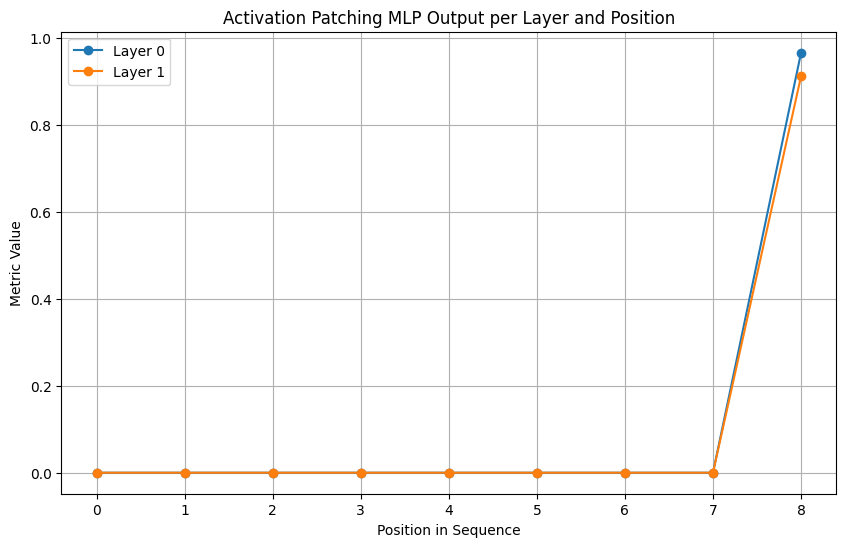

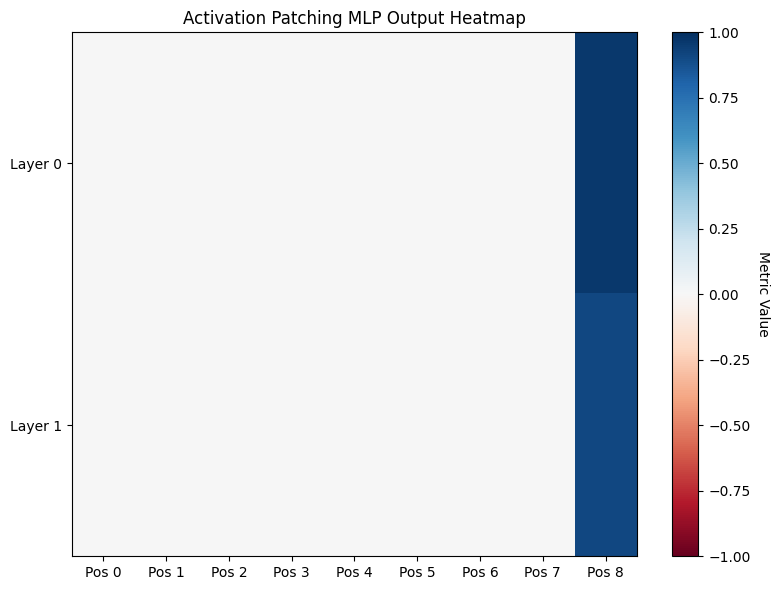

In [135]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming act_patch_mlp_out is the tensor obtained from your previous code
# For demonstration, here's a dummy tensor (remove this line in your actual code)
# act_patch_mlp_out = torch.rand(2, 7)

# Ensure the tensor is detached from the computation graph and moved to CPU
act_patch_mlp_out = act_patch_mlp_out.detach().cpu()

n_layers, n_positions = act_patch_mlp_out.shape

# Create a line plot for each layer
positions = np.arange(n_positions)
plt.figure(figsize=(10, 6))
for layer in range(n_layers):
    plt.plot(positions, act_patch_mlp_out[layer], marker="o", label=f"Layer {layer}")
plt.xlabel("Position in Sequence")
plt.ylabel("Metric Value")
plt.title("Activation Patching MLP Output per Layer and Position")
plt.xticks(positions)
plt.legend()
plt.grid(True)
plt.show()

# Create a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(act_patch_mlp_out, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels([f"Pos {i}" for i in positions])
ax.set_yticks(np.arange(n_layers))
ax.set_yticklabels([f"Layer {i}" for i in range(n_layers)])

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Metric Value", rotation=-90, va="bottom")

ax.set_title("Activation Patching MLP Output Heatmap")
plt.tight_layout()
plt.show()

## Probes

In [ ]:
# now we'll look for some expected features with linear probes

# ex: first character in sorted order
# ex: position 1 bigger than position 2

In [286]:
# want to look at each part along the residual stream
residual_stream_hook_names = [c for c in cache if 'resid' in c]

print(residual_stream_hook_names)

['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_mid', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_resid_mid', 'blocks.1.hook_resid_post']


In [296]:
# Dictionary to hold activations and targets for each residual stream hook
activations_dict = {hook_name: [] for hook_name in residual_stream_hook_names}

# keep track of corresponding inputs (because shuffling)
inputs_per_activation_list = []

In [297]:
model.eval()

for batch_index, batch in tqdm.tqdm(enumerate(train_loader)):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # ex: torch.Size([4, 9, 29])
    _, cache = model.run_with_cache(tokens)

    # store the residual stream at each hook point
    for hook_name in residual_stream_hook_names:
        hook_value = cache[hook_name].detach().cpu()
        activations_dict[hook_name].append(hook_value)

    # store inputs
    inputs_per_activation_list.append(tokens.detach().cpu())

714it [00:07, 92.31it/s] 


In [304]:
# stack the lists into single tensor
activations_per_residual_stream_hook = {
    k: torch.stack(v) for k, v in activations_dict.items()
}

inputs_per_activation = torch.stack(inputs_per_activation_list)

In [305]:
# fold the `num_batches` into the `batch` dimension
activations_per_residual_stream_hook = {
    k: einops.rearrange(v, 'batch_size batch seq d_model -> (batch_size batch) seq d_model')
    for k, v in activations_per_residual_stream_hook.items()
}

inputs_per_activation = einops.rearrange(inputs_per_activation, 'batch_size batch seq -> (batch_size batch) seq',)

In [307]:
for hook_name in residual_stream_hook_names:
    activations = activations_per_residual_stream_hook[hook_name]
    print(f'{hook_name} - {activations.shape=}')

print(f'{inputs_per_activation.shape=}')

blocks.0.hook_resid_pre - activations.shape=torch.Size([365568, 10, 16])
blocks.0.hook_resid_mid - activations.shape=torch.Size([365568, 10, 16])
blocks.0.hook_resid_post - activations.shape=torch.Size([365568, 10, 16])
blocks.1.hook_resid_pre - activations.shape=torch.Size([365568, 10, 16])
blocks.1.hook_resid_mid - activations.shape=torch.Size([365568, 10, 16])
blocks.1.hook_resid_post - activations.shape=torch.Size([365568, 10, 16])
inputs_per_activation.shape=torch.Size([365568, 10])


In [314]:
Char = str
TokenInt = int

def get_sorted_char_label_at_seq_pos(
    inputs: Int64[torch.Tensor, "seq"],
    char_sequence_position: int,
) -> Char:
    
    tokens_as_string = tokenizer.decode(inputs.tolist())

    # <abdc|abcd> -> <abdc -> abdc -> abcd
    sorted_tokens_as_string = sorted(tokens_as_string.split('|')[0][1:])

    return sorted_tokens_as_string[char_sequence_position]

def get_sorted_token_at_seq_pos(
    inputs: Int64[torch.Tensor, "seq"],
    char_sequence_position: int,
) -> TokenInt:
    token_char = get_sorted_char_label_at_seq_pos(inputs, char_sequence_position)
    return torch.tensor(tokenizer.encode(token_char))

In [318]:
tokens_as_string = '<adcb|abcd>'
tokens_as_ints = torch.tensor(tokenizer.encode(tokens_as_string))

assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 0) == 'a'
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 1) == 'b'
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 2) == 'c'
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 3) == 'd'


assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 0).tolist()) == 'a'
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 1).tolist()) == 'b'
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 2).tolist()) == 'c'
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 3).tolist()) == 'd'

In [323]:
import dataclasses
from jaxtyping import Int, jaxtyped
from typeguard import typechecked as typechecker

@dataclasses.dataclass
class LinearProbeDataset:
    activations: Float[torch.Tensor, "batch d_model"]
    labels: Float[torch.Tensor, "batch"]

@jaxtyped(typechecker=typechecker)
def prepare_dataset(
    activations: dict[str, Float[torch.Tensor, "batch seq d_model"]],
    inputs: Int64[torch.Tensor, "batch seq"],
    hook_name: str,
    position: int,
    char_sequence_position: int = 0,
) -> LinearProbeDataset:
    
    labels_list = []
    
    for batch_index in range(inputs.shape[0]):

        tokens: Int64[torch.Tensor, "seq"] = inputs[batch_index]

        label = get_sorted_token_at_seq_pos(tokens, char_sequence_position,)

        labels_list.append(label)

    labels: Int[torch.Tensor, "batch"] = torch.stack(labels_list)

    activations_for_hook: Float[torch.Tensor, "batch seq d_model"] = activations[hook_name]

    # slice at position
    activations_for_hook_at_position: Float[torch.Tensor, "batch d_model"] = activations_for_hook[:, position, :]
    return LinearProbeDataset(activations_for_hook_at_position, labels)

In [324]:
# TODO(bschoen): This is currently only looking at the first sorted character
linear_probe_dataset_per_position_per_hook_name: dict[str, dict[int, LinearProbeDataset]] = {}

for hook_name in tqdm.tqdm(activations_per_residual_stream_hook.keys()):

    linear_probe_dataset_per_position_per_hook_name[hook_name] = {}

    for position_index in range(inputs_per_activation.shape[-1]):

        linear_probe_dataset = prepare_dataset(
            activations=activations_per_residual_stream_hook,
            inputs=inputs_per_activation,
            hook_name=hook_name,
            position=position_index,
            char_sequence_position=0,
        )

        linear_probe_dataset_per_position_per_hook_name[hook_name][position_index] = linear_probe_dataset

100%|██████████| 6/6 [01:38<00:00, 16.37s/it]


In [282]:
import torch

class Order:
    LESS_THAN = -1
    EQUAL = 0
    GREATER_THAN = 1

def create_order_tensor(input_string: str) -> torch.Tensor:
    """
    Creates a PyTorch tensor representing the lexicographical order of characters in the input string.

    Args:
    input_string (str): The input string to analyze.

    Returns:
    torch.Tensor: A tensor of shape (len(input_string), len(input_string)) where tensor[i][j] is:
        1 if input_string[i] comes before input_string[j] in lexicographical order
        0 if input_string[i] is the same as input_string[j]
        -1 if input_string[i] comes after input_string[j] in lexicographical order
    """
    # Get the length of the input string
    n = len(input_string)
    
    # Create a tensor of zeros with shape (n, n)
    order_tensor = torch.zeros((n, n), dtype=torch.int)
    
    # Fill the tensor based on lexicographical order
    for i in range(n):
        for j in range(n):
            if i == j:
                # Same character, set to 0
                order_tensor[i, j] = Order.EQUAL
            elif input_string[i] < input_string[j]:
                # Character at i comes before character at j
                order_tensor[i, j] = Order.GREATER_THAN
            else:
                # Character at i comes after character at j
                order_tensor[i, j] = Order.LESS_THAN
    
    return order_tensor

# Example usage
input_string = "adbc"
order_tensor = create_order_tensor(input_string)
print(order_tensor)

tensor([[ 0,  1,  1,  1],
        [-1,  0, -1, -1],
        [-1,  1,  0,  1],
        [-1,  1, -1,  0]], dtype=torch.int32)


['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_mid', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_resid_mid', 'blocks.1.hook_resid_post']


tensor(-1, dtype=torch.int32)

In [278]:
import dataclasses

class SampleInfo:

    sorted_string_tokens: list[str]

sample_to_sample_info = []





Type:        list
String form: ['<iupp|ippu>', '<myzg|gmyz>', '<ibol|bilo>', '<qgbj|bgjq>', '<kcdx|cdkx>', '<nvfz|fnvz>', '<pwkn <...> lvvv>', '<ammz|ammz>', '<zzcv|cvzz>', '<lwew|elww>', '<amng|agmn>', '<cotl|clot>', '<xfvy|fvxy>']
Length:      365581
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

# Transcoders

In [268]:
# now that we've got a reasonable setup, let's train the transcoder (
# for sorting a fixed size list, we can see 100% of the activation comes
# from the final layer MLP)
from gpt_from_scratch import transcoder

transcoder_cfg = transcoder.TranscoderConfig.from_model(model=model, device=device)

transcoder_training_cfg = transcoder.TranscoderTrainingConfig(
    hook_point="blocks.1.hook_resid_mid",
    out_hook_point="blocks.1.hook_mlp_out",
    num_epochs=2000,
    learning_rate=1e-3,
    l1_coefficient=1.0,
)

mlp_transcoder = transcoder.Transcoder(transcoder_cfg)

mlp_transcoder = mlp_transcoder.to(device)

mlp_transcoder.train()

Transcoder()

In [269]:
import functools

import torch.nn.functional as F

# set model to eval since shouldn't change
model.eval()

# setup optimizers
optimizer = torch.optim.AdamW(
    mlp_transcoder.parameters(),  # Change this to optimize transcoder parameters
    lr=transcoder_training_cfg.learning_rate,
    weight_decay=0.1,
)

losses: list[float] = []

for epoch, batch in tqdm.tqdm(
    zip(
        range(transcoder_training_cfg.num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # we create small hooks which just store it in a local variable
    mlp_in = []
    mlp_out = []

    def mlp_in_hook_fn(input, hook):
        mlp_in.append(
            input.detach().clone()
        )  # Use clone() to avoid in-place modifications

    def mlp_out_hook_fn(input, hook):
        mlp_out.append(
            input.detach().clone()
        )  # Use clone() to avoid in-place modifications

    # Get MLP input and output activations
    model.run_with_hooks(
        tokens,
        fwd_hooks=[
            (transcoder_training_cfg.hook_point, mlp_in_hook_fn),
            (transcoder_training_cfg.out_hook_point, mlp_out_hook_fn),
        ],
        return_type=None,
    )

    assert len(mlp_in) == 1
    assert len(mlp_out) == 1

    mlp_in = mlp_in.pop().to(device)
    mlp_out = mlp_out.pop().to(device)

    # norm decoder
    # mlp_transcoder.set_decoder_norm_to_unit_norm()

    # transcoder_results.transcoder_out: Float[Tensor, "batch seq d_out"]
    # transcoder_results.hidden_activations: Float[Tensor, "batch seq d_hidden"]
    transcoder_results = mlp_transcoder(mlp_in)

    # Compute mean squared error
    mse: Float[torch.Tensor, ""] = F.mse_loss(
        transcoder_results.transcoder_out,
        mlp_out,
    )

    # Compute sparsity error (L1 norm of hidden activations)
    sparsity_error: Float[torch.Tensor, ""] = (
        transcoder_results.hidden_activations.abs().mean()
    )
    l1_loss: Float[torch.Tensor, ""] = (
        transcoder_training_cfg.l1_coefficient * sparsity_error
    )

    # Compute total loss as sum of MSE and L1 error
    loss: Float[torch.Tensor, ""] = mse + l1_loss

    # Create a TranscoderLoss object for consistency with the rest of the code
    loss_result = transcoder.TranscoderLoss(mse_loss=mse, l1_loss=l1_loss)

    # Backward pass and optimization
    loss.backward()

    losses.append(loss.item())

    optimizer.step()

    optimizer.zero_grad()

    if (epoch % 100) == 0:

        # Compute the mean activation over both batch and sequence dimensions
        # feature_sparsity.shape will be [hidden_size]
        feature_sparsity = (
            (transcoder_results.hidden_activations.abs() > 0).float().mean(dim=(0, 1))
        )

        # metrics for currents acts
        l0 = (transcoder_results.hidden_activations > 0).float().sum(-1).mean()

        # Print current batch index, loss, L0, and sparsity information
        print(
            (
                f"Epoch {epoch}: "
                f"Total Loss = {loss.item():.6f}, "
                f"MSE Loss = {loss_result.mse_loss.item():.6f}, "
                f"Sparsity Loss = {loss_result.l1_loss.item():.6f}, "
                f"L0 = {l0.item():.2f}, "  # Add L0 information
                f"Sparsity: min = {feature_sparsity.min().item():.4f}, "  # Add min sparsity
                f"max = {feature_sparsity.max().item():.4f}, "  # Add max sparsity
                f"mean = {feature_sparsity.mean().item():.4f}"  # Add mean sparsity
            )
        )

# log locally to sanity check
px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})

print(f"Final train loss: {loss.item():.6f}")

mlp_transcoder.eval()

7it [00:00, 32.51it/s]

Epoch 0: Total Loss = 0.136385, MSE Loss = 0.131718, Sparsity Loss = 0.004667, L0 = 1008.17, Sparsity: min = 0.0000, max = 1.0000, mean = 0.4923


108it [00:02, 41.67it/s]

Epoch 100: Total Loss = 0.002303, MSE Loss = 0.000008, Sparsity Loss = 0.002295, L0 = 374.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.1826


208it [00:05, 40.84it/s]

Epoch 200: Total Loss = 0.001697, MSE Loss = 0.000007, Sparsity Loss = 0.001690, L0 = 239.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.1167


306it [00:07, 28.41it/s]

Epoch 300: Total Loss = 0.001318, MSE Loss = 0.000004, Sparsity Loss = 0.001314, L0 = 162.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0791


409it [00:10, 40.69it/s]

Epoch 400: Total Loss = 0.000976, MSE Loss = 0.000002, Sparsity Loss = 0.000973, L0 = 110.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0537


509it [00:12, 41.15it/s]

Epoch 500: Total Loss = 0.000714, MSE Loss = 0.000001, Sparsity Loss = 0.000713, L0 = 71.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0347


609it [00:15, 41.10it/s]

Epoch 600: Total Loss = 0.000516, MSE Loss = 0.000001, Sparsity Loss = 0.000515, L0 = 43.89, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0214


709it [00:17, 41.08it/s]

Epoch 700: Total Loss = 0.000371, MSE Loss = 0.000001, Sparsity Loss = 0.000371, L0 = 21.01, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0103


806it [00:19, 48.54it/s]

Epoch 800: Total Loss = 0.000301, MSE Loss = 0.000000, Sparsity Loss = 0.000301, L0 = 5.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0024


907it [00:21, 48.22it/s]

Epoch 900: Total Loss = 0.000272, MSE Loss = 0.000000, Sparsity Loss = 0.000272, L0 = 2.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0010


1007it [00:23, 47.28it/s]

Epoch 1000: Total Loss = 0.000252, MSE Loss = 0.000000, Sparsity Loss = 0.000252, L0 = 2.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0010


1109it [00:26, 48.29it/s]

Epoch 1100: Total Loss = 0.000235, MSE Loss = 0.000000, Sparsity Loss = 0.000235, L0 = 2.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0010


1209it [00:28, 48.06it/s]

Epoch 1200: Total Loss = 0.000223, MSE Loss = 0.000000, Sparsity Loss = 0.000222, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1311it [00:30, 44.54it/s]

Epoch 1300: Total Loss = 0.000212, MSE Loss = 0.000000, Sparsity Loss = 0.000212, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1406it [00:32, 48.51it/s]

Epoch 1400: Total Loss = 0.000203, MSE Loss = 0.000000, Sparsity Loss = 0.000203, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1507it [00:34, 48.21it/s]

Epoch 1500: Total Loss = 0.000195, MSE Loss = 0.000000, Sparsity Loss = 0.000195, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1609it [00:36, 48.16it/s]

Epoch 1600: Total Loss = 0.000188, MSE Loss = 0.000000, Sparsity Loss = 0.000188, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1709it [00:38, 48.43it/s]

Epoch 1700: Total Loss = 0.000181, MSE Loss = 0.000000, Sparsity Loss = 0.000181, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1807it [00:40, 47.95it/s]

Epoch 1800: Total Loss = 0.000175, MSE Loss = 0.000000, Sparsity Loss = 0.000175, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


1908it [00:42, 46.95it/s]

Epoch 1900: Total Loss = 0.000169, MSE Loss = 0.000000, Sparsity Loss = 0.000169, L0 = 1.00, Sparsity: min = 0.0000, max = 1.0000, mean = 0.0005


2000it [00:44, 44.88it/s]

Final train loss: 0.000164


Transcoder()

In [224]:
# create a small (fixed) training set of each difficulty to use for visualization
test_example_per_difficulty = {}
for difficulty, test_loader in test_loaders.items():
    # grab something from the test batch
    x, _ = next(iter(test_loader))
    input_tokens = x[0].to(device)
    test_example_per_difficulty[difficulty] = input_tokens

In [233]:
# create a cache for each one
test_example_string_to_cache = {}

for difficulty, input_tokens in test_example_per_difficulty.items():

    logits, cache = model.run_with_cache(input_tokens)

    # store example by using the actual text string as key
    input_tokens_str = "".join([tokenizer.decode([x.item()]) for x in input_tokens])

    test_example_string_to_cache[input_tokens_str] = cache

In [273]:
assert (
    len(test_example_per_difficulty) == 1
), "Here we're assuming only one difficulty, can be easily adapted for more"


print(f"{transcoder_training_cfg.hook_point=}")
print(f"{transcoder_training_cfg.out_hook_point=}")

mlp_in = correct_cache[transcoder_training_cfg.hook_point]
mlp_out = correct_cache[transcoder_training_cfg.out_hook_point]

transcoder_results = mlp_transcoder(mlp_in)

# Print shapes of tensors
print([c for c in correct_string])
print(f"mlp_in: {mlp_in.shape}")
print(f"mlp_out: {mlp_out.shape}")
print(f"transcoder_out: {transcoder_results.transcoder_out.shape}")
print(f"hidden_activations: {transcoder_results.hidden_activations.shape}")

transcoder_training_cfg.hook_point='blocks.1.hook_resid_mid'
transcoder_training_cfg.out_hook_point='blocks.1.hook_mlp_out'
['<', 'b', 'a', 'c', 'd', '|', 'a', 'b', 'c']
mlp_in: torch.Size([1, 9, 16])
mlp_out: torch.Size([1, 9, 16])
transcoder_out: torch.Size([1, 9, 16])
hidden_activations: torch.Size([1, 9, 2048])


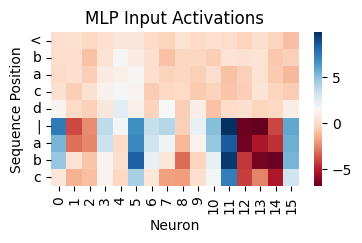

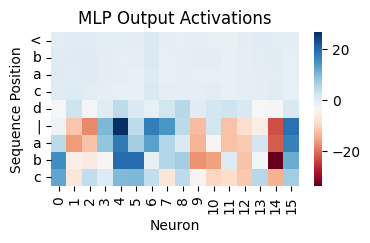

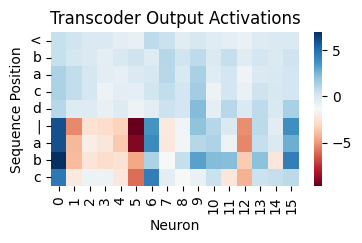

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Assuming you have imported or defined `mlp_in`, `mlp_out`, `transcoder_out`, `hidden_activations`, and `input_tokens_str`


# Function to plot heatmap of activations
def plot_activations(
    activations,
    title,
    xlabel="Neuron",
    ylabel="Sequence Position",
    tokens=None,
    cmap: str = "RdBu",
):
    # Remove batch dimension and convert to numpy
    activations = activations.squeeze(0).detach().cpu().numpy()
    plt.figure(figsize=(4, 2))
    sns.heatmap(activations, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if tokens is not None:
        plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0)
    plt.show()


# 1. Visualize MLP Input Activations (mlp_in)
plot_activations(mlp_in, title="MLP Input Activations", tokens=correct_string)

# 2. Visualize MLP Output Activations (mlp_out)
plot_activations(mlp_out, title="MLP Output Activations", tokens=correct_string)

# 3. Visualize Transcoder Output (transcoder_out)
plot_activations(
    transcoder_results.transcoder_out,
    title="Transcoder Output Activations",
    tokens=correct_string,
)

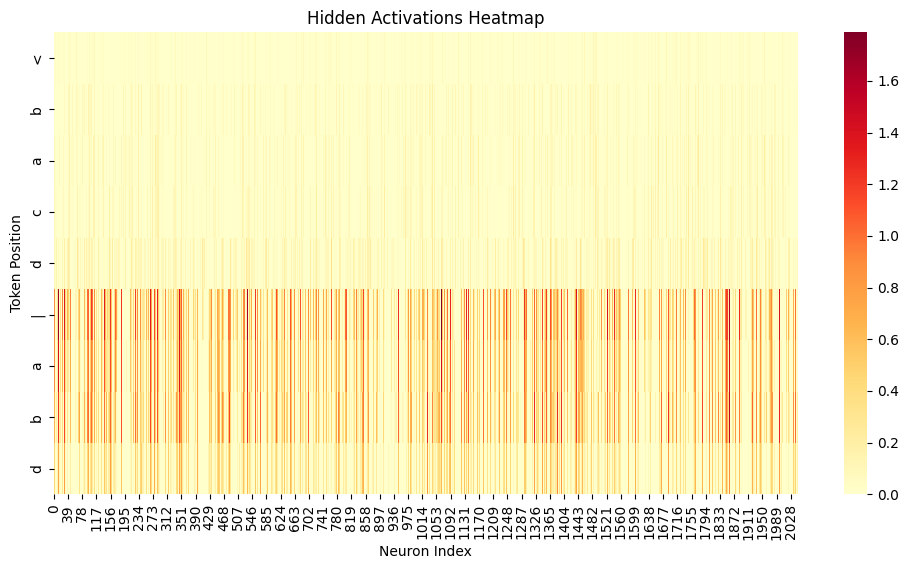

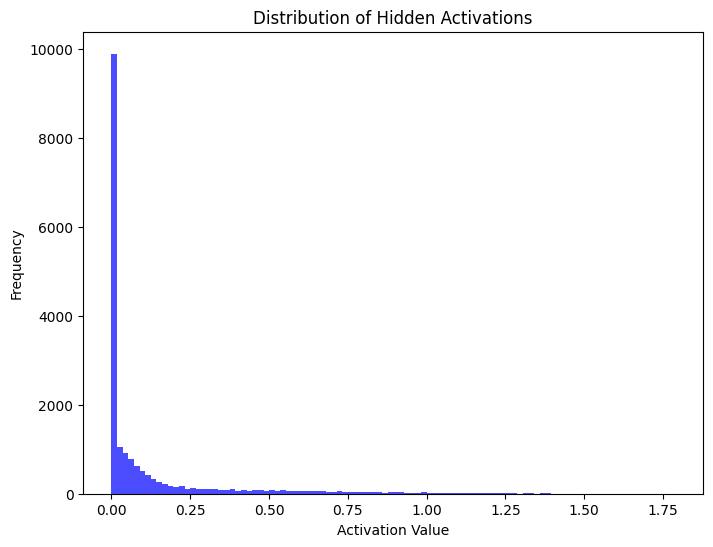

In [263]:
def visualize_hidden_activations(hidden_activations, tokens):
    # hidden_activations: [seq_len, hidden_size]
    # tokens: list of token strings

    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        hidden_activations,
        cmap="YlOrRd",
        cbar=True,
        vmin=0,
        vmax=np.max(hidden_activations),
    )
    plt.ylabel("Token Position")
    plt.xlabel("Neuron Index")
    plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=90)
    plt.title("Hidden Activations Heatmap")
    plt.show()

    # Activation Distribution
    activation_values = hidden_activations.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(activation_values, bins=100, color="blue", alpha=0.7)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Hidden Activations")
    plt.show()

    # PCA
    """from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    activations_pca = pca.fit_transform(hidden_activations)
    plt.figure(figsize=(8, 6))
    plt.scatter(
        activations_pca[:, 0],
        activations_pca[:, 1],
        c=np.arange(len(tokens)),
        cmap="viridis",
    )
    for i, token in enumerate(tokens):
        plt.text(activations_pca[i, 0], activations_pca[i, 1], token)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Hidden Activations")
    plt.colorbar(label="Token Position")
    plt.show()"""


visualize_hidden_activations(
    hidden_activations=transcoder_results.hidden_activations[0].detach().cpu().numpy(),
    tokens=incorrect_string,
)

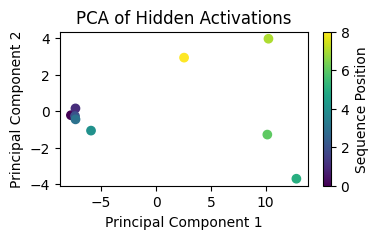

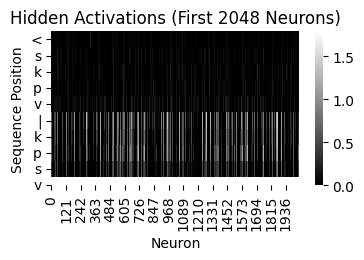

In [264]:
# 4. Visualize Hidden Activations of MLP (hidden_activations)
# Due to the high dimensionality (2048), we might need to reduce dimensions
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2 for visualization
activations = transcoder_results.hidden_activations.squeeze(0).detach().cpu().numpy()
pca = PCA(n_components=2)
reduced_activations = pca.fit_transform(activations.reshape(-1, activations.shape[-1]))

# Plot the PCA-reduced activations
plt.figure(figsize=(4, 2))
scatter = plt.scatter(
    reduced_activations[:, 0],
    reduced_activations[:, 1],
    c=np.arange(activations.shape[0]),
    cmap="viridis",
)
plt.colorbar(scatter, label="Sequence Position")
plt.title("PCA of Hidden Activations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Alternatively, plot a subset of neurons
num_neurons_to_plot = 2048  # Adjust based on preference
selected_neurons = activations[:, :num_neurons_to_plot]

plot_activations(
    torch.tensor(selected_neurons),
    title="Hidden Activations (First {} Neurons)".format(num_neurons_to_plot),
    xlabel="Neuron",
    tokens=input_tokens_str,
    cmap="grey",
)

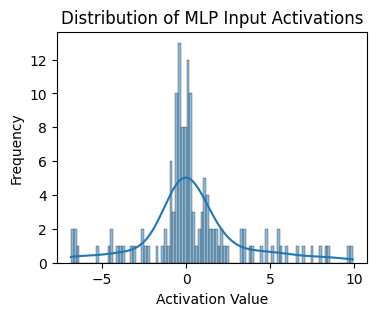

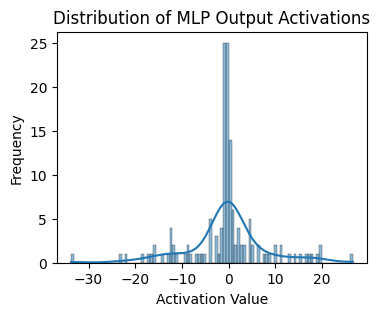

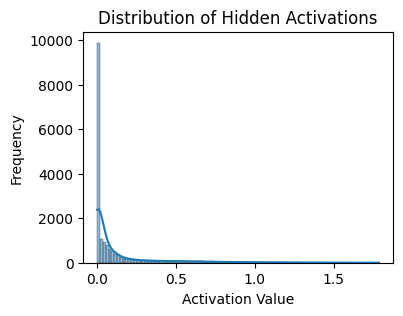

In [265]:
# 5. Visualize Distributions of Activations
def plot_activation_distribution(activations, title):
    activations = activations.detach().cpu().numpy().flatten()
    plt.figure(figsize=(4, 3))
    sns.histplot(activations, bins=100, kde=True)
    plt.title(title)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()


plot_activation_distribution(mlp_in, title="Distribution of MLP Input Activations")

plot_activation_distribution(mlp_out, title="Distribution of MLP Output Activations")

plot_activation_distribution(
    transcoder_results.hidden_activations,
    title="Distribution of Hidden Activations",
)

In [185]:
mlp = model.blocks[1].mlp

In [ ]:
mlp.W_out

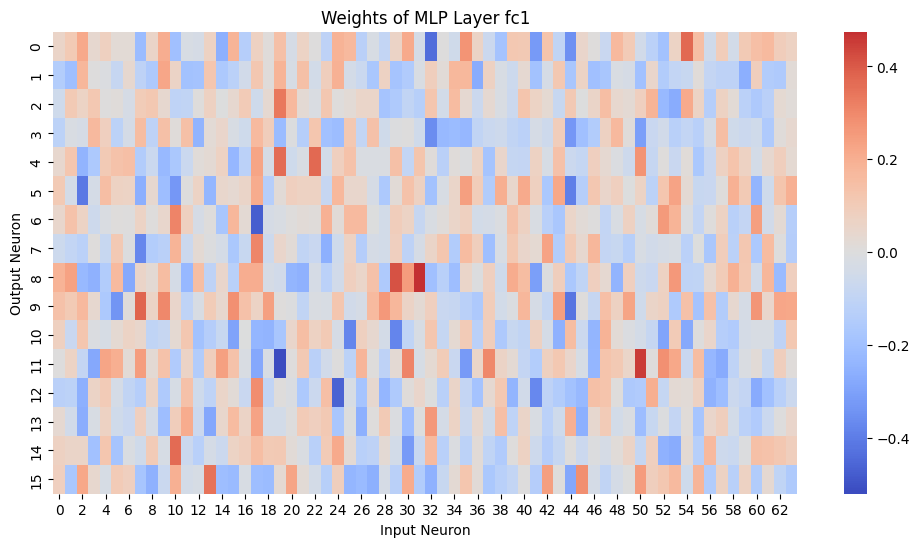

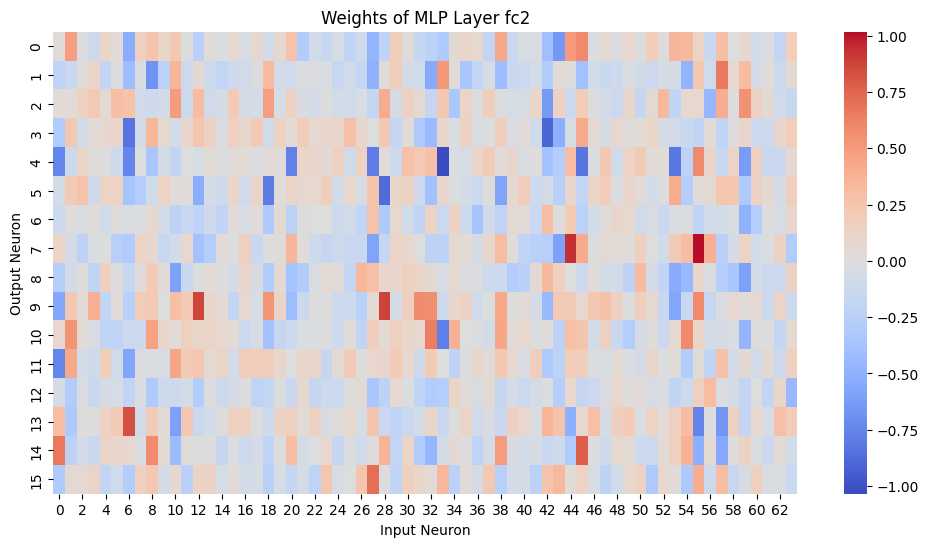

In [230]:
# 6. Visualize MLP Weights
# Assuming you have access to the MLP model
# Replace `model` with your transformer model variable and adjust layer indices accordingly

# Visualize weights of the first linear layer
weight_matrix = model.blocks[0].mlp.W_in.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(weight_matrix, cmap="coolwarm", center=0)
plt.title("Weights of MLP Layer fc1")
plt.xlabel("Input Neuron")
plt.ylabel("Output Neuron")
plt.show()

# Visualize weights of the second linear layer
weight_matrix = model.blocks[1].mlp.W_in.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(weight_matrix, cmap="coolwarm", center=0)
plt.title("Weights of MLP Layer fc2")
plt.xlabel("Input Neuron")
plt.ylabel("Output Neuron")
plt.show()

## Optuna Study

In [ ]:
import optuna


# TODO(bschoen): Do need to use lightning if want to do this generally
# note: generally do want to iterate on this part itself, i.e. once find promising learning rate, searching other hyperparameters
def objective(trial: optuna.Trial) -> float:

    # TODO(bschoen): up to one per position, eh might as well try it

    d_model = trial.suggest_categorical("d_model", [8, 16, 32, 64, 128])
    n_heads = trial.suggest_int("n_heads", 1, 8)

    cfg = ModelAndTrainingConfig(
        num_epochs=1000,
        eval_test_every_n=10000,  # not worth evaluating test loss for study
        n_layers=1,  # trial.suggest_int("n_layers", 1, 2),
        d_model=d_model,
        n_heads=n_heads,
        learning_rate=5e-4,
    )

    # sanity check `d_heads`
    if (cfg.d_model % cfg.n_heads) != 0:
        print(f"Pruning trial for {cfg.d_model=} {cfg.n_heads=}")
        raise optuna.exceptions.TrialPruned()

    result = train_model(cfg)

    return result.train_loss


enable_optuna = False

if enable_optuna:

    study_storage_url = "sqlite:///toy-problem-hooked-transformer.db"

    study = optuna.create_study(
        directions=[optuna.study.StudyDirection.MINIMIZE],
        storage=study_storage_url,
    )

    study.optimize(objective, n_trials=10)

    print("View by launching optuna dashboard from the command line:")
    print(f"optuna-dashboard {study_storage_url}")

    # now let's do a real run
    training_config = ModelAndTrainingConfig(
        num_epochs=10000,
        eval_test_every_n=1000,
        n_layers=1,
        d_model=16,
        n_heads=1,
    )

    result = train_model(cfg=training_config)

    # for compatibility with code later
    model = result.model
    cfg = training_config.get_hooked_transformer_config()

In [ ]:
# Look at some example output
import circuitsvis as cv

import functools


def visualize_pattern_hook(
    pattern: Float32[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: transformer_lens.hook_points.HookPoint,
    tokens_as_strings: list[str],
) -> None:
    print(f"Batch size: {pattern.shape[0]}")
    print("Layer: ", hook.layer())
    display(
        cv.attention.attention_patterns(
            tokens=tokens_as_strings, attention=pattern.mean(0)
        )
    )


test_input_string_to_cache = {}

for difficulty, test_loader in test_loaders.items():

    print(difficulty)

    # grab something from the test batch
    example_batch = next(iter(test_loader))

    x, y = example_batch

    example_sample = x[0]

    # example_sample = torch.tensor(tokenizer.encode("<az|za|az>>>>>>>>>>"))

    # grab the first part of it, ex: `<abc|`
    example_prompt = example_sample  # [:8]

    example_prompt = example_prompt.to(device)

    print(f"Using {example_prompt} from {example_sample} (from test set)")

    # note: already encoded
    input_tokens = example_prompt

    # first let's get these as strings so can easily work with them
    input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

    # wrap to bind input tokens
    visualize_pattern_hook_fn = functools.partial(
        visualize_pattern_hook, tokens_as_strings=input_tokens_as_strings
    )

    model.run_with_hooks(
        input_tokens,
        return_type=None,  # For efficiency, we don't need to calculate the logits
        fwd_hooks=[(lambda name: name.endswith("pattern"), visualize_pattern_hook_fn)],
    )

    logits_batch, cache = model.run_with_cache(input_tokens)

    # store so can plot together later
    test_input_string_to_cache["".join(input_tokens_as_strings)] = cache

    logits = logits_batch[0]

    log_probs = logits.log_softmax(dim=-1)

    cv.logits.token_log_probs(
        token_indices=input_tokens,
        log_probs=log_probs,
        to_string=token_to_string,
    )

In [ ]:
cache.apply_ln_to_stack?

In [ ]:
cache.stack_head_results??

In [ ]:
import transformer_lens.patching

transformer_lens.patching.get_act_patch_resid_pre??

In [ ]:
import einops


def logit_attribution(
    embed: Float32[torch.Tensor, "seq d_model"],
    l1_results: Float32[torch.Tensor, "seq nheads d_model"],
    l2_results: Float32[torch.Tensor, "seq nheads d_model"],
    W_U: Float32[torch.Tensor, "d_model d_vocab"],
    tokens: Int64[torch.Tensor, "seq"],
) -> Float32[torch.Tensor, "seq-1 n_components"]:
    """
    Inputs:
        embed: the embeddings of the tokens (i.e. token + position embeddings)
        l1_results: the outputs of the attention heads at layer 1 (with head as one of the dimensions)
        l2_results: the outputs of the attention heads at layer 2 (with head as one of the dimensions)
        W_U: the unembedding matrix
        tokens: the token ids of the sequence

    Returns:
        Tensor of shape (seq_len-1, n_components)
        represents the concatenation (along dim=-1) of logit attributions from:
            the direct path (seq-1,1)
            layer 0 logits (seq-1, n_heads)
            layer 1 logits (seq-1, n_heads)
        so n_components = 1 + 2*n_heads
    """
    W_U_correct_tokens = W_U[:, tokens[1:]]
    # SOLUTION
    direct_attributions = einops.einsum(
        W_U_correct_tokens, embed[:-1], "emb seq, seq emb -> seq"
    )
    l1_attributions = einops.einsum(
        W_U_correct_tokens, l1_results[:-1], "emb seq, seq nhead emb -> seq nhead"
    )
    l2_attributions = einops.einsum(
        W_U_correct_tokens, l2_results[:-1], "emb seq, seq nhead emb -> seq nhead"
    )
    return torch.concat(
        [direct_attributions.unsqueeze(-1), l1_attributions, l2_attributions], dim=-1
    )


logits, cache = model.run_with_cache(input_tokens, remove_batch_dim=True)
str_tokens = input_tokens_as_strings
tokens = input_tokens

with t.inference_mode():
    embed = cache["embed"]
    l1_results = cache["result", 0]
    l2_results = cache["result", 1]
    logit_attr = logit_attribution(
        embed,
        l1_results,
        l2_results,
        model.W_U,
        tokens[0],
    )

    # Uses fancy indexing to get a len(tokens[0])-1 length tensor, where the kth entry is the predicted logit for the correct k+1th token
    correct_token_logits = logits[0, torch.arange(len(tokens[0]) - 1), tokens[0, 1:]]

## Looking at it with CircuitsViz

In [ ]:
# before even going to SAE, let's look at circuitsviz here
import circuitsvis as cv

import circuitsvis.activations
import circuitsvis.attention
import circuitsvis.logits
import circuitsvis.tokens
import circuitsvis.topk_samples
import circuitsvis.topk_tokens

In [ ]:
# first let's see what we have
import tabulate

print(f"{len(input_tokens)=}")

# show the first few elements of the `HookedTransformerConfig`, since that has things like `d_model`, num heads, etc
print(tabulate.tabulate([(k, v) for k, v in cfg.__dict__.items()][:10]))

print(tabulate.tabulate([(k, v.shape) for k, v in cache.items()]))

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256

import numpy as np
import pandas as pd

from bokeh.io import output_notebook

import seaborn as sns

import matplotlib.pyplot as plt

# Enable Bokeh output in the notebook
output_notebook()


def tensor_to_dataframe(
    tensor: torch.Tensor, labels: list[str], tokens: list[str]
) -> pd.DataFrame:
    """
    Convert a 2D PyTorch tensor to a pandas DataFrame.

    Args:
        tensor (torch.Tensor): A 2D tensor to convert.

    Returns:
        pd.DataFrame: A DataFrame representation of the input tensor.

    Raises:
        ValueError: If the input tensor is not 2D.
    """
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.dim()}D")
    if len(labels) != 2:
        raise ValueError(f"Expected labels for both dimensions, got {len(labels)}")

    # Convert tensor to numpy array
    numpy_array = tensor.detach().cpu().numpy()

    # Create DataFrame
    df = pd.DataFrame(numpy_array)

    # Name the index the first label
    df.index.name = labels[0]

    # Name the columns the second label
    df.columns = [f"{labels[1]}_{i}" for i in range(numpy_array.shape[1])]

    return df


def visualize_tensor_heatmap(
    tensor: torch.Tensor,
    title: str = "Tensor Heatmap",
    colormap: list[str] = Viridis256,
    width: int = 800,
    height: int = 400,
) -> None:
    """
    Visualize a 2D tensor as a heatmap.

    Args:
        tensor (torch.Tensor): A 2D tensor to visualize.
        title (str): Title of the heatmap.
        colormap (List[str]): A list of colors to use for the heatmap.
        width (int): Width of the plot in pixels.
        height (int): Height of the plot in pixels.

    """

    # Ensure tensor is 2D
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.shape}")

    # convert tensor to dataframe
    df = tensor_to_dataframe(tensor)

    # Create a 2D grid of coordinates
    y, x = np.mgrid[0 : data.shape[0], 0 : data.shape[1]]

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = data.flatten()

    # Create a ColumnDataSource
    source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            z=z,
            color=Viridis256[:: int(256 / len(z))][: len(z)],  # Map values to colors
        )
    )

    # Create the figure
    p = figure(
        title="Tensor Heatmap",
        x_range=(0, data.shape[1]),
        y_range=(0, data.shape[0]),
        toolbar_location="below",
        tools="pan,wheel_zoom,box_zoom,reset",
    )

    # Add rectangular glyphs
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=source,
        fill_color="color",
        line_color=None,
    )

    # Add hover tool
    hover = HoverTool(tooltips=[("x", "@x"), ("y", "@y"), ("value", "@z{0.000}")])
    p.add_tools(hover)

    # Invert y-axis to match tensor indexing
    p.y_range.start, p.y_range.end = p.y_range.end, p.y_range.start

    # Show the plot
    show(p)

In [ ]:
print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [ ]:
# let's go ahead and just use first batch
def first_batch(tensor: Float32[torch.Tensor, "b t c"]) -> Float32[torch.Tensor, "t c"]:
    return tensor[0]

In [ ]:
model

In [31]:
import torch.nn as nn

from typing import Iterable, TypeVar

import tabulate

T = TypeVar("T")


# alias for `print(tabulate.tabulate(data))`
def print_table(data: T) -> None:
    print(tabulate.tabulate(data))


# Define a function to print module weights recursively
def print_module_weights(module: nn.Module) -> Iterable[tuple[str, str]]:
    """
    Recursively prints the weights of a PyTorch module and its submodules.

    This function traverses through the module hierarchy, printing information
    about parameters that require gradients and are not hook-related.

    Example:
        >>> print_table(print_module_weights(model))

        ------------------  ----------------------
        embed.W_E           torch.Size([29, 14])
        pos_embed.W_pos     torch.Size([9, 14])
        blocks.0.ln1.w      torch.Size([14])
        blocks.0.ln1.b      torch.Size([14])
        blocks.0.ln2.w      torch.Size([14])
        blocks.0.ln2.b      torch.Size([14])
        blocks.0.attn.W_Q   torch.Size([3, 14, 4])
        blocks.0.attn.W_O   torch.Size([3, 4, 14])
        blocks.0.attn.b_Q   torch.Size([3, 4])
        blocks.0.attn.b_O   torch.Size([14])
        blocks.0.attn.W_K   torch.Size([3, 14, 4])
        blocks.0.attn.W_V   torch.Size([3, 14, 4])
        blocks.0.attn.b_K   torch.Size([3, 4])
        blocks.0.attn.b_V   torch.Size([3, 4])
        blocks.0.mlp.W_in   torch.Size([14, 56])
        blocks.0.mlp.b_in   torch.Size([56])
        blocks.0.mlp.W_out  torch.Size([56, 14])
        blocks.0.mlp.b_out  torch.Size([14])
        ln_final.w          torch.Size([14])
        ln_final.b          torch.Size([14])
        unembed.W_U         torch.Size([14, 29])
        unembed.b_U         torch.Size([29])
        ------------------  ----------------------

    Args:
        module (nn.Module): The PyTorch module to inspect.
        prefix (str, optional): A string prefix for indentation in the output.
                                Defaults to an empty string.

    Returns:
        Iterable[tuple[str, str]]: A list of tuples, where each tuple contains
            the name and shape of the parameter.
    """

    # Iterate through named parameters of the module
    for name, param in module.named_parameters():

        # Check if parameter requires gradient and doesn't start with 'hook_'
        if param.requires_grad and not name.startswith("hook_"):

            # yield parameter name and type
            yield f"{name}", f"{param.shape}"


def print_cache(cache: transformer_lens.ActivationCache) -> None:
    print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [ ]:
print("Weights in the model:")
print_table(print_module_weights(model))

In [32]:
print("Cached activations:")
print_cache(cache)

Cached activations:


NameError: name 'cache' is not defined

In [ ]:
def plot_cache_activation(
    cache: transformer_lens.ActivationCache,
    cache_key: str,
    input_tokens_as_strings: list[str],
) -> None:

    activations = first_batch(cache[cache_key])

    figsize = (4, 4)

    # make figure smaller for vectors
    if activations.shape[-1] == 1:
        figsize = (4, 1.5)

    # for larger activations like MLP, allow it to be taller
    elif activations.shape[-1] > 20:
        figsize = (4, 12)

    plt.figure(figsize=figsize)

    sns.heatmap(
        activations.cpu().numpy().T,
        cmap="coolwarm",
        center=0,
        xticklabels=input_tokens_as_strings,
    )

    plt.title(cache_key)

    # TODO(bschoen): Allow specifying this
    #
    plt.ylabel("Embedding Dimension")
    plt.xlabel("Token")

    plt.tight_layout()
    plt.show()


for cache_key in [
    "hook_embed",
    "hook_pos_embed",
    "blocks.0.hook_resid_pre",
    "blocks.0.ln1.hook_scale",
    "blocks.0.ln1.hook_normalized",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.ln2.hook_scale",
    "blocks.0.ln2.hook_normalized",
    "blocks.0.mlp.hook_pre",
    "blocks.0.mlp.hook_post",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "ln_final.hook_scale",
    "ln_final.hook_normalized",
]:

    plot_cache_activation(
        cache=cache,
        cache_key=cache_key,
        input_tokens_as_strings=input_tokens_as_strings,
    )

In [ ]:
# visualize MLP

import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_mlp_weights_and_biases(model):
    # Function to plot heatmaps for MLP weights and biases

    def plot_weight_bias_pair(weight, bias, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.heatmap(weight.detach().cpu().numpy(), ax=ax1, cmap="coolwarm", center=0)
        ax1.set_title(f"{title} - Weights")
        ax1.set_xlabel("Output dimension")
        ax1.set_ylabel("Input dimension")

        sns.heatmap(
            bias.detach().cpu().numpy().reshape(-1, 1),
            ax=ax2,
            cmap="coolwarm",
            center=0,
        )
        ax2.set_title(f"{title} - Biases")
        ax2.set_xlabel("Bias")
        ax2.set_ylabel("Dimension")

        plt.tight_layout()
        plt.show()

    # MLP weights and biases
    plot_weight_bias_pair(
        model.blocks[0].mlp.W_in, model.blocks[0].mlp.b_in, "MLP Input"
    )
    plot_weight_bias_pair(
        model.blocks[0].mlp.W_out, model.blocks[0].mlp.b_out, "MLP Output"
    )

    # Layer Norm final
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        model.ln_final.w.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=1,
    )
    plt.title("Layer Norm Final - Weights")
    plt.subplot(1, 2, 2)
    sns.heatmap(
        model.ln_final.b.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=0,
    )
    plt.title("Layer Norm Final - Biases")
    plt.tight_layout()
    plt.show()

    # Unembed
    plot_weight_bias_pair(model.unembed.W_U, model.unembed.b_U, "Unembed")


# Call the function
plot_mlp_weights_and_biases(model)

# Comment: Additional visualizations that could be useful:
# 1. Histograms of weight/bias distributions
# 2. 3D surface plots for weights to show patterns
# 3. Network architecture diagram with weight magnitudes represented by line thickness
# 4. Animated heatmaps showing weight changes during training

In [ ]:
def plot_weight_bias_activation(
    weight,
    bias,
    activation,
    title: str,
) -> None:

    activation = first_batch(activation)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    sns.heatmap(weight.detach().cpu().numpy().T, ax=ax1, cmap="coolwarm", center=0)
    ax1.set_title(f"{title} - Weight")

    sns.barplot(x=list(range(len(bias))), y=bias.detach().cpu().numpy(), ax=ax2)
    ax2.set_title(f"{title} - Bias")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Value")

    sns.heatmap(activation.detach().cpu().numpy().T, ax=ax3, cmap="coolwarm", center=0)
    ax3.set_title(f"{title} - Activation")

    plt.tight_layout()
    plt.show()


plot_weight_bias_activation(
    model.embed.W_E,
    torch.zeros(model.embed.W_E.shape[1]),
    cache["hook_embed"],
    "Embedding",
)
plot_weight_bias_activation(
    model.pos_embed.W_pos,
    torch.zeros(model.pos_embed.W_pos.shape[1]),
    cache["hook_pos_embed"],
    "Positional Embedding",
)

In [ ]:
# TODO(bschoen): Hook residual pre?

In [ ]:
# Plotting LayerNorm components


def plot_layernorm(scale, normalized, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    scale = first_batch(scale)
    normalized = first_batch(normalized)

    sns.barplot(
        x=list(range(len(scale))), y=scale.squeeze().detach().cpu().numpy(), ax=ax1
    )
    ax1.set_title(f"{title} - Scale")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Value")

    sns.heatmap(normalized.detach().cpu().numpy().T, ax=ax2, cmap="coolwarm", center=0)
    ax2.set_title(f"{title} - Normalized")

    plt.tight_layout()
    plt.show()


plot_layernorm(
    cache["blocks.0.ln1.hook_scale"],
    cache["blocks.0.ln1.hook_normalized"],
    "LayerNorm 1",
)

In [ ]:
# Plotting MLP components
plot_weight_bias_activation(
    model.blocks[0].mlp.W_in,
    model.blocks[0].mlp.b_in,
    cache["blocks.0.mlp.hook_pre"],
    "MLP Input",
)
plot_weight_bias_activation(
    model.blocks[0].mlp.W_out,
    model.blocks[0].mlp.b_out,
    cache["blocks.0.mlp.hook_post"],
    "MLP Output",
)

#### circuitsvis.activations

In [ ]:
# tokens := List of tokens if single sample (e.g. `["A", "person"]`) or list of lists of tokens (e.g. `[[["A", "person"], ["is", "walking"]]]`)
# activations := Activations of the shape [tokens x layers x neurons] if single sample or list of [tokens x layers x neurons] if multiple samples

# take first batch for now
activations = cache["blocks.0.hook_mlp_out"][0]
print(f"{activations.shape=}")

# reshape [tokens x neurons] -> [tokens x 1 x neurons]
#  - `-1` means to automatically infer the size of the last dimension
activations_view = activations.view(len(input_tokens), cfg.n_layers, -1)

print(f"{activations_view.shape=}")

# convert to strings (which this function expects)
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

# TODO(bschoen): Is there a way to essentially stack these? Claude can probably give the React for that

# so here we can visualize activations for a `torch.Size([1, 8, 16])`, which is most
# of them since this is the size of the embedding dimension
circuitsvis.activations.text_neuron_activations(
    tokens=[token_to_string(x.item()) for x in input_tokens],
    activations=activations_view,
)

#### circuitsvis.attention

In [ ]:
# tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length as the list of values.
# attention: Attention head activations of the shape [dest_tokens x src_tokens]
# max_value: Maximum value. Used to determine how dark the token color is when positive (i.e. based on how close it is to the maximum value).
# min_value: Minimum value. Used to determine how dark the token color is when negative (i.e. based on how close it is to the minimum value).
# negative_color: Color for negative values
# positive_color: Color for positive values.
# show_axis_labels: Whether to show axis labels.
# mask_upper_tri: Whether or not to mask the upper triangular portion of the attention patterns. Should be true for causal attention, false for bidirectional attention.


# take first batch
# ex: torch.Size([4, 8, 8]) -> [n_heads, n_ctx, n_ctx]
# note: `blocks.0.attn.hook_attn_scores` is too early (not normalized?)
attention = cache["blocks.0.attn.hook_pattern"][0]

print(f"{attention.shape=}")

circuitsvis.attention.attention_heads(
    tokens=input_tokens_as_strings,
    attention=attention,
    max_value=1,
    min_value=-1,
    negative_color="blue",
    positive_color="red",
    mask_upper_tri=True,
)

#### circuitsvis.logits

In [ ]:
# this is the normal one we usually show, i.e.
# cv.logits.token_log_probs(
#     token_indices=input_tokens,
#     log_probs=log_probs,
#     to_string=token_to_string,
# )

#### circuitsvis.tokens

In [ ]:
# for example, we'll look at each

# take first batch, ex: torch.Size([8, 16])
pos_embed = cache["hook_pos_embed"][0]

# low level function for coloring tokens according to single value
for i in range(cfg.d_model):
    display(
        circuitsvis.tokens.colored_tokens(
            tokens=input_tokens_as_strings,
            values=pos_embed[:, i],
            negative_color="blue",
            positive_color="red",
        )
    )

    # only display a few for example
    # if i >= 2:
    #    break

In [ ]:
# take first batch
# ex: torch.size([8, 16]) = [n_ctx, d_model]
attention_out = cache["blocks.0.hook_attn_out"][0]

circuitsvis.tokens.colored_tokens_multi(
    tokens=input_tokens_as_strings,
    values=attention_out,
    labels=[str(x) for x in range(cfg.d_model)],
)

In [ ]:
circuitsvis.tokens.visualize_model_performance(
    tokens=input_tokens,
    str_tokens=input_tokens_as_strings,
    logits=logits,
)

#### circuitsvis.topk_samples

In [ ]:
circuitsvis.topk_samples.topk_samples??

#### circuitsvis.topk_tokens

In [ ]:
circuitsvis.topk_tokens.topk_tokens??

## SAE

In [ ]:
for layer_index in range(cfg.n_layers):
    imshow(
        transformer_lens.utils.to_numpy(cache["attn", layer_index].mean([0, 1])),
        title=f"Layer {layer_index} Attention Pattern",
        height=400,
        width=400,
    )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dataclasses

Loss = Float32[torch.Tensor, ""]
MSELoss = Float32[torch.Tensor, ""]
WeightedSparsityLoss = Float32[torch.Tensor, ""]

Logits = Float32[torch.Tensor, "n_ctx d_vocab"]
BatchedLogits = Float32[torch.Tensor, "batch n_ctx d_vocab"]

ModelActivations = Float32[torch.Tensor, "n_ctx d_model"]
BatchedModelActivations = Float32[torch.Tensor, "batch n_ctx d_model"]

FlattenedModelActivations = Float32[torch.Tensor, "d_sae_in"]

BatchedFlattenedModelActivations = Float32[torch.Tensor, "batch d_sae_in"]
BatchedSAEActivations = Float32[torch.Tensor, "batch d_sae_model"]


@dataclasses.dataclass
class SAEOutput:
    sae_activations: BatchedSAEActivations
    reconstructed_model_activations: BatchedFlattenedModelActivations


def sparse_loss_kl_divergence(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_target: float,
    sparsity_weight: float,
    epsilon: float = 1e-7,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # same as dense loss (this is constant?)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # KL divergence for sparsity
    avg_activation = torch.mean(sae_output.sae_activations, dim=0)

    # print(f'[pre-clamping] {avg_activation=}')

    # Add epsilon for numerical stability
    avg_activation = torch.clamp(avg_activation, epsilon, 1 - epsilon)

    kl_div = sparsity_target * torch.log(sparsity_target / avg_activation) + (
        1 - sparsity_target
    ) * torch.log((1 - sparsity_target) / (1 - avg_activation))
    kl_div = torch.sum(kl_div)

    # `sparsity_weight` decides how much we weight `KL-Divergence`
    sparsity_penalty = sparsity_weight * kl_div

    # print(f"{mse_loss=}, {avg_activation=}, {kl_div.item()}, {sparsity_penalty=}")

    return mse_loss + sparsity_penalty, mse_loss, sparsity_penalty

In [ ]:
def sparse_loss_l1_norm(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_weight: float,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # Reconstruction loss (Mean Squared Error)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # L1 sparsity penalty
    l1_penalty = torch.mean(torch.abs(sae_output.sae_activations))

    sparsity_penalty = sparsity_weight * l1_penalty

    # Total loss
    total_loss = mse_loss + sparsity_penalty

    return total_loss, mse_loss, sparsity_penalty

In [ ]:
import dataclasses


@dataclasses.dataclass
class SparseAutoencoderConfig:
    d_in: int
    d_model: int


# TODO(bschoen): Start using the config pattern, it stays typesafe and allows
#                easy logging to things like wandb
class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        cfg: SparseAutoencoderConfig,
    ) -> None:

        print(f"Creating SparseAutoencoder with {cfg}")

        super(SparseAutoencoder, self).__init__()

        self.d_in = cfg.d_in
        self.d_model = cfg.d_model

        self.encoder = nn.Linear(cfg.d_in, cfg.d_model)
        self.decoder = nn.Linear(cfg.d_model, cfg.d_in)

    def forward(
        self,
        x: BatchedFlattenedModelActivations,
    ) -> SAEOutput:

        # TODO(bschoen): Which activation function should we use?
        encoded = F.gelu(self.encoder(x))

        decoded = self.decoder(encoded)

        return SAEOutput(
            sae_activations=encoded,
            reconstructed_model_activations=decoded,
        )

In [ ]:
import lightning.pytorch


@dataclasses.dataclass
class LightningSparseAutoencoderConfig:

    model_config: transformer_lens.HookedTransformerConfig
    sae_config: SparseAutoencoderConfig
    learning_rate: float
    sparsity_weight: float


# note: this kind of lightning adapter is a common pattern: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#starter-example
class LightningSparseAutoencoder(lightning.pytorch.LightningModule):
    def __init__(
        self,
        cfg: LightningSparseAutoencoderConfig,
    ) -> None:

        super(LightningSparseAutoencoder, self).__init__()

        self.model = transformer_lens.HookedTransformer(cfg=cfg.model_config)
        self.sae = SparseAutoencoder(cfg=cfg.sae_config)
        self.cfg = cfg

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx: int) -> Loss:
        inputs, target = batch

        self.model
        output = self(inputs, target)
        loss = torch.nn.functional.cr(output, target.view(-1))
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [ ]:
hook_id = "blocks.0.hook_mlp_out"

cache[hook_id].shape

In [ ]:
# Training loop
sae_num_epochs = 100000
sae_expansion_factor = 64

learning_rate = 5e-4

# both arbitrary for now
# - Start small: A common approach is to begin with a relatively small sparsity weight,
#                typically in the range of 1e-5 to 1e-3. This allows the model to
#                learn meaningful representations before enforcing strong sparsity
#                constraints.
sparsity_weight: float = 1e-3  # Weight of the sparsity loss in the total loss
sparsity_target: float = 0.05  # Target average activation of hidden neurons

print(f"Training SAE for {hook_id}...")
sae_d_in = (cfg.n_ctx - 1) * cfg.d_model  # -1 since not predicting first token
sae_d_model = sae_d_in * sae_expansion_factor

sae_cfg = SparseAutoencoderConfig(
    d_in=sae_d_in,
    d_model=sae_d_model,
)

sae_model = SparseAutoencoder(cfg=sae_cfg)
sae_model.to(device)

sae_optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

wandb.init(
    project="toy-problem-hooked-transformer-sae",
    config={
        "sae_num_epochs": sae_num_epochs,
        "sae_expansion_factor": sae_expansion_factor,
        "learning_rate": learning_rate,
        "sparsity_weight": sparsity_weight,
        "sparsity_target": sparsity_target,
        "sae_d_in": sae_d_in,
        "sae_d_model": sae_d_model,
        "hook_id": hook_id,
    },
)

# put model itself into eval mode so doesn't change
model.eval()

# go through the training data again, this time training the sae on the activations
for epoch, batch in tqdm.tqdm(
    zip(
        range(sae_num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run through the model (with cache) to get the activations
    logits, cache = model.run_with_cache(tokens)

    # ex: torch.Size([4, 8, 16])
    activations = cache[hook_id]

    # ex: torch.Size([4, 128])
    flattened_activations = activations.reshape(activations.size(0), -1)

    sae_optimizer.zero_grad()

    # now the SAE model is given the *activations*
    sae_output = sae_model.forward(flattened_activations)

    # compute loss

    total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_kl_divergence(
        flattened_activations,
        sae_output,
        sparsity_target=sparsity_target,
        sparsity_weight=sparsity_weight,
    )

    """total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_l1_norm(
        flattened_model_activations=flattened_activations,
        sae_output=sae_output,
        sparsity_weight=sparsity_weight,
    )"""

    total_loss.backward()

    sae_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Step {epoch}, "
            f"Total Loss: {total_loss.item():.6f}, "
            f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
            f"Sparsity Loss: {weighted_sparsity_loss.item():.6f}",
        )

        wandb.log(
            {
                "epoch": epoch,
                "total_loss": total_loss.item(),
                "reconstruction_loss": reconstruction_loss.item(),
                "weighted_sparsity_loss": weighted_sparsity_loss.item(),
            }
        )

wandb.finish()

#### Dictionary Learning Implementation

See [simple_dictionary_learning.ipynb](simple_dictionary_learning.ipynb) for a details

#### Extracting the learned dictionary

In [ ]:
# Creating SparseAutoencoder with d_in=128, d_model=512, sparsity_target=0.05
dictionary: Float32[torch.Tensor, "sae_hidden sae_in"] = (
    sae_model.encoder.weight.detach()
)

# ex: Dictionary shape: torch.Size([512, 128])
print(f"Dictionary shape: {dictionary.shape}")

In [ ]:
# Reshape dictionary elements to match original activation shape
# (essentially `unflatting`)
reshaped_dictionary = dictionary.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

# Motivation: Extract the learned features (dictionary elements) from the encoder weights
# ex: Dictionary shape: torch.Size([512, 8, 16])
print(f"Dictionary shape: {reshaped_dictionary.shape}")

In [ ]:
# It's always worth checking this sort of thing when you do this by hand
# to check that you haven't got the wrong site, or are missing a
# scaling factor or something like this.
#
# This is like the overfitting thing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# let's look at an example batch from `test`

# set both to eval mode
model.eval()
sae_model.eval()

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

_, cache = model.run_with_cache(x)

activations = cache[hook_id]

print(f"Activations shape: {activations.shape}")

# flatten it
flattened_activations = activations.reshape(activations.size(0), -1)

print(f"{flattened_activations.shape=}")

sae_outputs = sae_model(flattened_activations)

print(f"{sae_outputs.sae_activations.shape=}")
print(f"{sae_outputs.reconstructed_model_activations.shape=}")

# now we can get the dictionary
dictionary = sae_model.encoder.weight.detach()

print(f"Dictionary shape: {dictionary.shape}")

# now we can get the sparse coefficients
alpha = dictionary @ flattened_activations.T

### Determine Quality Of SAE

In [ ]:
def calculate_sparsity(
    sae_activations: BatchedSAEActivations,
    threshold: float = 1e-5,
) -> float:
    """
    Calculate sparsity of SAE activations across a batch.

    Args:
    sae_activations (torch.Tensor): The activations from the Sparse Autoencoder.
                                    Shape: (batch, d_sae_model)
    threshold (float): The threshold below which an activation is considered "inactive".

    Returns:
    float: The average sparsity value across the batch (fraction of inactive neurons).
    """
    # Count the number of neurons that are below the threshold (inactive)
    inactive_neurons = torch.sum(torch.abs(sae_activations) < threshold, dim=1)

    # Calculate the fraction of inactive neurons for each item in the batch
    sparsity_per_item = inactive_neurons.float() / sae_activations.shape[1]

    # Take the mean across the batch
    average_sparsity = torch.mean(sparsity_per_item)

    return average_sparsity.item()

In [ ]:
def calculate_explained_variance(
    reconstructed_model_activations: BatchedFlattenedModelActivations,
    flattened_activations: BatchedFlattenedModelActivations,
) -> float:
    """
    Calculate the explained variance of the SAE activations.
    """

    numerator = torch.mean(
        (reconstructed_model_activations[:, 1:] - flattened_activations[:, 1:]) ** 2
    )
    denominator = flattened_activations[:, 1:].to(torch.float32).var()

    explained_variance = 1 - (numerator / denominator)

    return explained_variance.item()

In [ ]:
# explained_variance=0.995 -> good, basically all the variance is explained by our SAE
# sparsity=0.0045 -> good, very sparse, and more sparse than our target of 0.05
explained_variance = calculate_explained_variance(
    sae_outputs.reconstructed_model_activations,
    flattened_activations,
)
print(f"{explained_variance=:.4f}")

sparsity = calculate_sparsity(sae_outputs.sae_activations)
print(f"{sparsity=:.4f}")

In [ ]:
# Let's analyze the relationship between SAE activations and input features

# TODO(bschoen): Oh `imshow` is huge here!

# 1. Visualize the dictionary (encoder weights)
plt.figure(figsize=(12, 8))
plt.imshow(dictionary.cpu().T, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("SAE Dictionary (Encoder Weights)")
plt.xlabel("Dictionary Elements")
plt.ylabel("Input Features")
plt.show()

In [ ]:
# 2. Find the most active neurons for each input
top_k = 5  # Number of top activations to consider

# so this is essentially the top 5 activations over `batch_size` examples
top_activations = torch.topk(sae_outputs.sae_activations, k=top_k, dim=1)

# Visualization of top activations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.heatmap(
    top_activations.values.detach().cpu().numpy(), cmap="viridis", annot=True, fmt=".2f"
)
plt.title("Top 5 Activation Values")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.subplot(2, 1, 2)
sns.heatmap(
    top_activations.indices.detach().cpu().numpy(), cmap="YlOrRd", annot=True, fmt="d"
)
plt.title("Indices of Top 5 Activations")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.tight_layout()
plt.show()

# Additional analysis: frequency of top neurons
top_neuron_counts = torch.bincount(
    top_activations.indices.flatten().detach().cpu(),
    minlength=sae_outputs.sae_activations.shape[1],
)
top_10_neurons = torch.topk(top_neuron_counts, k=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), top_10_neurons.values.detach().cpu().numpy())
plt.title("Top 10 Most Frequently Activated Neurons")
plt.xlabel("Neuron Index")
plt.ylabel("Activation Frequency")
plt.xticks(range(10), top_10_neurons.indices.detach().cpu().numpy())
plt.show()

In [ ]:
sae_outputs.sae_activations[:, 1210]

In [ ]:
print(f"{sae_outputs.sae_activations.shape=}")
print(f"{top_activations.values.shape=}")
print(f"{top_activations.indices.shape=}")

In [ ]:
print(top_activations.indices)

In [ ]:
# ex: 51 and 410 show up a lot
sns.heatmap(top_activations.values.cpu().T, cmap="viridis")

In [ ]:
# 3. Analyze feature importance for each neuron
feature_importance = torch.abs(dictionary).sum(dim=1)
top_features = torch.topk(feature_importance, k=10)

print(f"{dictionary.shape=}")
print(f"{feature_importance.shape=}")
print(f"{top_features.values.shape=}")
print(f"{top_features.indices.shape=}")

top_features

In [ ]:
print("\nTop 10 most important neurons:")
for i, (value, index) in enumerate(
    zip(top_features.values.tolist(), top_features.indices.tolist())
):
    print(f"Neuron {index}:\t{value:.4f}")

In [ ]:
top_features.values.tolist()

In [ ]:
top_features.indices.tolist()

In [ ]:
# 4. Visualize activations for a few examples

# first look at a single batch
sae_activations = sae_outputs.sae_activations[0].detach().cpu()

print(f"{sae_activations.shape=}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)

# Look at a single batch
plt.bar(range(sae_activations.shape[0]), sae_activations)

plt.title(f"SAE Activations for Example")
plt.xlabel("Neuron")
plt.ylabel("Activation")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Reconstruct input features from SAE activations
#
# Take a single batch first
reconstructed_model_activations = (
    sae_outputs.reconstructed_model_activations.detach().cpu()
)

# 6. Compare original and reconstructed features
num_features = 5

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.ylim(-1, 1)  # Set y-axis range from -1 to 1
    plt.plot(flattened_activations[:, i].cpu(), label="Original", alpha=0.5)
    plt.plot(reconstructed_model_activations[:, i], label="Reconstructed", alpha=0.5)
    plt.title(f"Feature {i}: Original vs Reconstructed")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. Correlation between SAE activations and input features
correlation_matrix = torch.corrcoef(
    torch.cat([sae_outputs.sae_activations, flattened_activations], dim=1).T
)
num_neurons = sae_outputs.sae_activations.shape[1]
neuron_feature_correlation = correlation_matrix[:num_neurons, num_neurons:]

plt.figure(figsize=(12, 8))
plt.imshow(
    neuron_feature_correlation.detach().cpu(),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar()
plt.title("Correlation between SAE Neurons and Input Features")
plt.xlabel("Input Features")
plt.ylabel("SAE Neurons")
plt.show()

In [ ]:
sae_outputs.sae_activations

In [ ]:
# collect max activations


with torch.no_grad():

    # go through the training data again, but don't cycle, no reason to go through more than once
    for batch in tqdm.tqdm(train_loader):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # run through the model (with cache) to get the activations
        logits, cache = model.run_with_cache(tokens)

        # ex: torch.Size([4, 8, 16])
        activations = cache[hook_id]

        # ex: torch.Size([4, 128])
        flattened_activations = activations.reshape(activations.size(0), -1)

        # now the SAE model is given the *activations*
        encoded, decoded = sae_model(flattened_activations)

        sae_activations = encoded

        # sae_activations.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

        # max_activations = torch.max(encoded, dim=1)

        break

In [ ]:
alpha = sae_model.encoder.weight @ flattened_activations[0]

print(f"{alpha.shape=}")

In [ ]:
torch.mean(torch.abs(alpha))

In [ ]:
sae_activations[0].shape

In [ ]:
8 * 16